# Third Practicals:  Integrated Gradients (IG) as an Explainable Technique

In this practical session, we will 
 * learn about Integrated Gradients (IG) implemeted in Julia on Gene Expression data.
 * build a simple neural network and train it to classify cells.
 * apply the IG on the gene expression data and invistigate the results. 
 * Discuss: how to choose a baseline for IG?

## Interpretablity in Machine Learning

we will start off by having a look at the taxonomy of the interpretablity methods. (probably was shown by my colleague **Martin** ) 

![](figures/taxonomy.webp)

## Integrated gradients (IG)

IG is an explainable technique with many uses case, including but not limited to feature importance. The main aim of IG is to explain the relationship between the **model's prediction** & the **features** of the data without sacrificing accuracy. 

### Let's see IG applied on images
![](figures/mask.png)

## The Theory behind Integrated Gradients

We will walk through the mathematics behind integrated gradients; then we will turn the equations into a Julia code.

### Let's have a look at the formula and break it down:

![](figures/IG_eq1.png)

**Where**<br>
$i$ = featrure <br>
$x_{i}$ = input <br> 
$x^\prime$ = baseline <br> 
$\alpha$ = interpolation constant <br> 

### We find an approximation to compute the integral numerically 

![](figures/IG_app.png)

**Where**<br>
$i$ = featrure <br>
$x_{i}$ = input <br> 
$x^\prime$ = baseline <br> 
$k$ = scaled feature perturbation constant <br> 
$m$ = number of steps in the Riemann sum approximation of the integral <br> 
$(x_{i}^{\prime} - x_{i})$ a term for the difference from the baselin <br> 
 <br> 

Now let's see the above-mentioned formula as a Julia code ...  

## Setting up the environment
(Same from first practical session)
In the `Project.toml` and `Manifest.toml` file in the folder in the repository, all the necessary packages and their versions are specified. We don't have to manually install them, but can simply tell Julia to configure the environment as specified in these files, including installing all necessary dependencies. This can be done with the Julia package manager with the following commands: 

For more info on the Julia package manager, see [here](https://docs.julialang.org/en/v1/stdlib/Pkg/)

In [3]:
using Pkg; # loading the package manager
cd(@__DIR__) # change into the directory where the current file (this notebook) is located
Pkg.activate(".") # activate the environment specified in the .toml files
Pkg.instantiate() # install the necessary dependencies
Pkg.status() # show which packages are currently installed in the environment
using ForwardDiff
using StatsBase
using Images, Plots;

  Activating project at `~/GCB_Workshop/gcb2022-sc-gen-tutorial/PracticalsIII`


Status `~/GCB_Workshop/gcb2022-sc-gen-tutorial/PracticalsIII/Project.toml`
  [4fba245c] ArrayInterface v6.0.22
  [159f3aea] Cairo v1.0.5
  [aaaa29a8] Clustering v0.14.2
  [5ae59095] Colors v0.12.8
  [a93c6f00] DataFrames v1.3.4
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.68
  [587475ba] Flux v0.13.5
  [f6369f11] ForwardDiff v0.10.32
  [28b8d3ca] GR v0.66.2
  [92fee26a] GZip v0.5.1
  [c91e804a] Gadfly v1.3.4
  [916415d5] Images v0.25.2
⌃ [eb30cadb] MLDatasets v0.5.16
  [3b7a836e] PGFPlots v3.4.2
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.31.7
  [92933f4c] ProgressMeter v1.7.2
  [d330b81b] PyPlot v2.11.0
  [2913bbd2] StatsBase v0.33.21
  [24678dba] TSne v1.3.0
  [c4f8c510] UMAP v0.1.9
  [112f6efa] VegaLite v2.6.0
⌃ [fdbf4ff8] XLSX v0.8.2
  [add38077] scVI v0.1.0 `https://github.com/maren-ha/scVI.jl#main`
  [8bb1440f] DelimitedFiles
  [10745b16] Statistics
Info Packages marked with ⌃ have new versions available


Let's train a model that classifies the cells ... 

## Load the data (same dataset from first practical session)

We will use a dataset from Tasic et al. (2016), where gene expression is profiled in 1525 single neurons, extracted from the cortices of mice. The authors reported a set of 104 genes (Figure 3 of Tasic et al.), based on which different subtypes of neurons can be discriminated and a set of 80 neurotransmitter receptor genes (Figure S15 of Tasic et al.), totalling to 184 genes. 

The data from Tasic et al. (2016) has been stored in the [Gene expression Omnibus (GEO)](https://www.ncbi.nlm.nih.gov/geo/) under accession number GSE71585. 

We have downloaded the expression data and the correspoding sample description sheet from the GEO and removed the samples from the expression data which have been flagged by Tasic et al. (2016) as being of bad quality. Since the samples of bad quality are not contained within the sample description sheet, we can filter the samples of bad quality by comparing the sample IDs in the expression data with the IDs in the sample description sheet. 

Further, we have removed genes which are expressed with less than 10 aligned reads in less than 20 samples. This is necessary since many genes are usually expressed only in a single cell and consequently these genes do not substantially represent the structure in the data.

Next, the data has been normalized for sequencing depth using an algorithm from DESeq (Anders and Huber, 2010).
Normalization for sequencing depth is important since the number of aligned reads per sample fluctuate which affects the estimated expression level for each gene. The algorithm of Anders and Huber (2010) calculates correction factors, one for each sequencing library, i.e. sample, by which the sequencing data are divided. 

The data contains expression levels of over 15.119 genes in 1679 samples. To lower computational demands of the following analysis while still maintaining most of the biological signal int he dataset, we have subsetted the data using a set of genes identified as most relevant by Tasic et al. (2016): Specifically, we use the marker genes which are known to indicate cell type membership ([Figure 3](https://www.nature.com/articles/nn.4216/figures/3) in Tasic et al. (2016)) and the neurotransmitter receptorgenes which are differentially expressed in different neuron cell types but have a less pronounced expression pattern (supplementary material, [Figure S 15](https://static-content.springer.com/esm/art%3A10.1038%2Fnn.4216/MediaObjects/41593_2016_BFnn4216_MOESM67_ESM.pdf))
 
Finally, we selected only the neural cells using the cell type annotation provided by Tasic et al. (2016), and annotated the cell types as GABAergic vs. Glutamatergic. 

The complete preprocessing can be reproduced by running the script `preprocess_Tasic.jl`, where at the end the following four files are saved to the `data` subfolder: 

 * `genes.txt` - list of selected genes 
 * `single_cell_mat` - the normalized count matrix, subsetted to the relevant genes and neural cells 
 * `celltype.txt` - the cell type annotation of the cells in `single_cell_mat.txt`, as provided by Tasic et al. (2016)
 * `gabagluta.txt` - the annotation of cells as GABAergic vs. Glutamatergic. 

In [4]:
using DelimitedFiles
genenames = readdlm("data/genes.txt")
mat_norm = readdlm("data/single_cell_mat.txt")
celltype = readdlm("data/celltype.txt")
gabagluta = readdlm("data/gabagluta.txt");

We can check how many genes and cells we have, and some more information about the number of different cell types and Gaba- vs Glutamatergic cells: 

In [5]:
ngenes, ncells = size(mat_norm)
ncelltypes = length(unique(celltype))
ngaba = length(gabagluta[gabagluta.=="GABA"])
ngluta = length(gabagluta[gabagluta.=="Glutamate"])

println("Data matrix is of size ", size(mat_norm))
println("Number of genes is ", length(genenames))
println("Number of cells is ", length(celltype))

println("There are $ncelltypes different cell types")
println("There are $ngaba GABA-ergic cells and $ngluta Glutamatergic cells")

Data matrix is of size (180, 1525)
Number of genes is 180
Number of cells is 1525
There are 15 different cell types
There are 761 GABA-ergic cells and 764 Glutamatergic cells


In [6]:
using scVI
adata = scVI.load_tasic()

AnnData object with a countmatrix with 1679 cells and 15119 genes
   layers dict with the following keys: ["normalized_counts", "counts"]
   unique celltypes: ["Vip", "L4", "L2/3", "L2", "Pvalb", "Ndnf", "L5a", "SMC", "Astro", "L5", "Micro", "Endo", "Sst", "L6b", "Sncg", "Igtp", "Oligo", "Smad3", "OPC", "L5b", "L6a"]
   training status: not trained


In [7]:
# we take a subset of the data ... 
subset_tasic!(adata)

AnnData object with a countmatrix with 1525 cells and 180 genes
   layers dict with the following keys: ["normalized_counts", "counts"]
   unique celltypes: ["Vip", "L4", "L2/3", "L2", "Pvalb", "Ndnf", "L5a", "L5", "Sst", "L6b", "Sncg", "Igtp", "Smad3", "L5b", "L6a"]
   training status: not trained


In [8]:
nclasses = length(unique(adata.celltypes))
println("The number of classes: ",  nclasses)

The number of classes: 15


### Build a simple classification model using `Flux`:

In [9]:
function ClassNet(; ngenes=180, nclasses=15) 
    
    nhidden = 128
    class_model = Chain(Dense(ngenes, nhidden, relu),
                    Dense(nhidden,nclasses))
    return class_model
end

ClassNet (generic function with 1 method)

In [10]:
class_model = ClassNet()

Chain(
  Dense(180 => 128, relu),              # 23_168 parameters
  Dense(128 => 15),                     # 1_935 parameters
)                   # Total: 4 arrays, 25_103 parameters, 98.309 KiB.

In [11]:
## Utility function returns the number of parameters ... 
num_params(model) = sum(length, Flux.params(model)) 
round4(x) = round(x, digits=4)
#num_of_params = num_params(conv_model)
@info "Classification Model model has: $(num_params(class_model)) trainable params"

┌ Info: Classification Model model has: 25103 trainable params
└ @ Main In[11]:5


In [12]:
# Training Parameters 
# we set up training parameters 
Base.@kwdef mutable struct Args
    η = 1e-5            ## learning rate
    λ = 0                ## L2 regularizer param, implemented as weight decay
    batchsize = 128      ## batch size
    epochs = 1000          ## number of epochs
    seed = 0             ## set seed > 0 for reproducibility
    use_cuda = false      ## if true use cuda (if available)
    infotime = 1 	     ## report every `infotime` epochs
    checktime = 5        ## Save the model every `checktime` epochs. Set to 0 for no checkpoints.
    tblogger = true      ## log training with tensorboard
    savepath = "runs/"   ## results path
end

Args

In [13]:
# split the data to train and test .. 
function get_data(args)
    
    labels = unique(adata.celltypes)
    
    ytrain = Flux.onehotbatch(adata.celltypes[1:1000], labels)
    Xtrain = (log.(adata.countmatrix'[:, 1:1000].+1))
    train_loader = DataLoader((Xtrain,ytrain), batchsize=args.batchsize,shuffle=true)
    
    # Load train & test in dataloaders as mini-batches of data of size: 128 
    ytest = Flux.onehotbatch(adata.celltypes[1001:end], labels)
    Xtest = (log.(adata.countmatrix'[:, 1001:end].+1))
    test_loader = DataLoader((Xtest, ytest),  batchsize=args.batchsize)
    
    return train_loader, test_loader
end

get_data (generic function with 1 method)

## Define a Loss Function: Cross Entropy

![](figures/cross_entropy.png)

In [19]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

loss (generic function with 1 method)

In [18]:
function eval_loss_accuracy(loader, model, device) # device = cpu since I don't have gpu on my machine ....
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in loader
        x, y = x |> device, y |> device
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(onecold(ŷ |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

eval_loss_accuracy (generic function with 1 method)

In [21]:
using Flux
using Flux.Data: DataLoader
using Flux.Optimise: Optimiser, WeightDecay
using Flux: onehotbatch, onecold, flatten
using Flux.Losses: logitcrossentropy
using Statistics, Random
using Logging: with_logger
using TensorBoardLogger: TBLogger, tb_overwrite, set_step!, set_step_increment!
using ProgressMeter: @showprogress
import MLDatasets
import BSON
using Plots

## Training the Classification Model 

In [22]:
# Let's train the model ... 

function train(; kws...)
    args = Args(; kws...)
    # create seed ....
    args.seed > 0 && Random.seed!(args.seed)
    use_cuda = args.use_cuda && CUDA.functional()
    
    if use_cuda
        device = gpu
        @info "Training on GPU"
    else
        device = cpu
        @info "Training on CPU"
    end

    ## Get the data ... 
    train_loader, test_loader = get_data(args)
    @info "Dataset: $(train_loader.nobs) train and $(test_loader.nobs) test examples"

    ## Create MODEL & optimizer 
    model = ClassNet()|> device
    @info "ClassNet5 model: $(num_params(model)) trainable params"    
    
    ps = Flux.params(model)  
    
    # We use ADAM ... 
    opt = ADAM(args.η) 
    if args.λ > 0 ## add weight decay, equivalent to L2 regularization
        opt = Optimiser(WeightDecay(args.λ), opt)
    end
    
    ## Log with tensorboard ...
    if args.tblogger 
        tblogger = TBLogger(args.savepath, tb_overwrite)
        set_step_increment!(tblogger, 0) ## 0 auto increment since we manually set_step!
        @info "TensorBoard logging at \"$(args.savepath)\""
    end
    ## Report a validation loss and accuracy ...
    function report(epoch)
        train = eval_loss_accuracy(train_loader, model, device)
        test = eval_loss_accuracy(test_loader, model, device)        
        println("Epoch: $epoch   Train: $(train)   Test: $(test)")
        if args.tblogger
            set_step!(tblogger, epoch)
            with_logger(tblogger) do
                @info "train" loss=train.loss  acc=train.acc
                @info "test"  loss=test.loss   acc=test.acc
            end
        end
    end
    
    ## START TRAINING
    @info "Start Training"
    report(0)
    trainloss = []
    testloss = []
    
    trainacc = []
    testacc = []
    for epoch in 1:args.epochs
        @showprogress for (x, y) in train_loader
            x, y = x |> device, y |> device
            gs = Flux.gradient(ps) do
                    ŷ = model(x)
                    loss(ŷ, y)
                end

            Flux.Optimise.update!(opt, ps, gs)
        end
        
        ## Printing and logging
        epoch % args.infotime == 0 && report(epoch)
        if args.checktime > 0 && epoch % args.checktime == 0
            !ispath(args.savepath) && mkpath(args.savepath)
            modelpath = joinpath(args.savepath, "model.bson") 
            let model = cpu(model) ## return model to cpu before serialization
                BSON.@save modelpath model epoch
            end
            @info "Model saved in \"$(modelpath)\""
        end
            train_eval_acc = eval_loss_accuracy(train_loader, model, device)
            test_eval_acc = eval_loss_accuracy(test_loader, model, device)
            push!(trainloss,train_eval_acc.loss )
            push!(testloss, test_eval_acc.loss)
            
            push!(trainacc,train_eval_acc.acc )
            push!(testacc,train_eval_acc.acc )
            
    end
    return model, test_loader ,trainloss, testloss, trainacc, testacc
end

train (generic function with 1 method)

In [23]:
model, test_loader,trainloss, testloss, trainacc, testacc = train();

┌ Info: Training on CPU
└ @ Main In[22]:14
┌ Info: Dataset: 1000 train and 525 test examples
└ @ Main In[22]:19
┌ Info: ClassNet5 model: 25103 trainable params
└ @ Main In[22]:23
┌ Info: TensorBoard logging at "runs/"
└ @ Main In[22]:37
┌ Info: Start Training
└ @ Main In[22]:54


Epoch: 0   Train: (loss = 5.0721f0, acc = 16.5)   Test: (loss = 5.3188f0, acc = 6.6667)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


Epoch: 1   Train: (loss = 4.9948f0, acc = 16.0)   Test: (loss = 5.2392f0, acc = 6.6667)
Epoch: 2   Train: (loss = 4.9204f0, acc = 16.1)   Test: (loss = 5.1615f0, acc = 6.8571)
Epoch: 3   Train: (loss = 4.8482f0, acc = 15.9)   Test: (loss = 5.0868f0, acc = 7.0476)
Epoch: 4   Train: (loss = 4.7784f0, acc = 15.6)   Test: (loss = 5.0143f0, acc = 7.0476)
Epoch: 5   Train: (loss = 4.71f0, acc = 15.6)   Test: (loss = 4.9436f0, acc = 6.8571)
Epoch: 6   Train: (loss = 4.644f0, acc = 15.2)   Test: (loss = 4.8755f0, acc = 6.6667)
Epoch: 7   Train: (loss = 4.5793f0, acc = 15.0)   Test: (loss = 4.8101f0, acc = 6.6667)
Epoch: 8   Train: (loss = 4.5162f0, acc = 14.8)   Test: (loss = 4.7459f0, acc = 6.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 9   Train: (loss = 4.4556f0, acc = 14.7)   Test: (loss = 4.685f0, acc = 6.4762)
Epoch: 10   Train: (loss = 4.3964f0, acc = 14.7)   Test: (loss = 4.6251f0, acc = 6.6667)
Epoch: 11   Train: (loss = 4.3378f0, acc = 14.5)   Test: (loss = 4.5665f0, acc = 6.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 12   Train: (loss = 4.2809f0, acc = 14.6)   Test: (loss = 4.5102f0, acc = 6.6667)
Epoch: 13   Train: (loss = 4.2254f0, acc = 15.0)   Test: (loss = 4.456f0, acc = 6.6667)
Epoch: 14   Train: (loss = 4.171f0, acc = 14.8)   Test: (loss = 4.4029f0, acc = 6.8571)
Epoch: 15   Train: (loss = 4.1176f0, acc = 14.9)   Test: (loss = 4.3512f0, acc = 6.6667)
Epoch: 16   Train: (loss = 4.0658f0, acc = 14.7)   Test: (loss = 4.3015f0, acc = 6.4762)
Epoch: 17   Train: (loss = 4.0147f0, acc = 15.0)   Test: (loss = 4.2524f0, acc = 6.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 18   Train: (loss = 3.9645f0, acc = 15.0)   Test: (loss = 4.205f0, acc = 6.6667)
Epoch: 19   Train: (loss = 3.9156f0, acc = 15.0)   Test: (loss = 4.1581f0, acc = 7.0476)
Epoch: 20   Train: (loss = 3.8678f0, acc = 15.2)   Test: (loss = 4.1131f0, acc = 7.0476)
Epoch: 21   Train: (loss = 3.8207f0, acc = 15.4)   Test: (loss = 4.0695f0, acc = 7.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 22   Train: (loss = 3.7743f0, acc = 15.7)   Test: (loss = 4.0266f0, acc = 7.2381)
Epoch: 23   Train: (loss = 3.7289f0, acc = 15.6)   Test: (loss = 3.9849f0, acc = 7.4286)
Epoch: 24   Train: (loss = 3.6844f0, acc = 15.7)   Test: (loss = 3.9444f0, acc = 7.619)
Epoch: 25   Train: (loss = 3.6409f0, acc = 16.0)   Test: (loss = 3.9046f0, acc = 7.619)
Epoch: 26   Train: (loss = 3.5977f0, acc = 16.4)   Test: (loss = 3.8658f0, acc = 7.619)
Epoch: 27   Train: (loss = 3.5555f0, acc = 16.5)   Test: (loss = 3.8265f0, acc = 7.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 28   Train: (loss = 3.5141f0, acc = 16.6)   Test: (loss = 3.7896f0, acc = 7.8095)
Epoch: 29   Train: (loss = 3.4734f0, acc = 16.5)   Test: (loss = 3.7534f0, acc = 7.8095)
Epoch: 30   Train: (loss = 3.4336f0, acc = 16.5)   Test: (loss = 3.7184f0, acc = 7.8095)
Epoch: 31   Train: (loss = 3.3944f0, acc = 16.6)   Test: (loss = 3.6839f0, acc = 8.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 32   Train: (loss = 3.3562f0, acc = 16.6)   Test: (loss = 3.6501f0, acc = 8.0)
Epoch: 33   Train: (loss = 3.3186f0, acc = 16.7)   Test: (loss = 3.6166f0, acc = 8.1905)
Epoch: 34   Train: (loss = 3.282f0, acc = 16.9)   Test: (loss = 3.5851f0, acc = 8.1905)
Epoch: 35   Train: (loss = 3.246f0, acc = 17.4)   Test: (loss = 3.5539f0, acc = 8.1905)
Epoch: 36   Train: (loss = 3.2101f0, acc = 17.8)   Test: (loss = 3.5231f0, acc = 8.1905)
Epoch: 37   Train: (loss = 3.1753f0, acc = 17.8)   Test: (loss = 3.4929f0, acc = 8.381)
Epoch: 38   Train: (loss = 3.1414f0, acc = 17.9)   Test: (loss = 3.4641f0, acc = 8.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 39   Train: (loss = 3.1077f0, acc = 18.4)   Test: (loss = 3.4349f0, acc = 8.5714)
Epoch: 40   Train: (loss = 3.0747f0, acc = 19.0)   Test: (loss = 3.4077f0, acc = 8.7619)
Epoch: 41   Train: (loss = 3.0421f0, acc = 19.0)   Test: (loss = 3.3801f0, acc = 8.7619)
Epoch: 42   Train: (loss = 3.01f0, acc = 19.2)   Test: (loss = 3.3534f0, acc = 9.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 43   Train: (loss = 2.979f0, acc = 19.7)   Test: (loss = 3.3283f0, acc = 9.9048)
Epoch: 44   Train: (loss = 2.9485f0, acc = 20.0)   Test: (loss = 3.3026f0, acc = 10.2857)
Epoch: 45   Train: (loss = 2.9182f0, acc = 20.1)   Test: (loss = 3.2779f0, acc = 10.6667)
Epoch: 46   Train: (loss = 2.8882f0, acc = 20.5)   Test: (loss = 3.2536f0, acc = 10.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 47   Train: (loss = 2.8591f0, acc = 20.4)   Test: (loss = 3.229f0, acc = 10.8571)
Epoch: 48   Train: (loss = 2.8304f0, acc = 20.5)   Test: (loss = 3.2062f0, acc = 11.0476)
Epoch: 49   Train: (loss = 2.8021f0, acc = 20.9)   Test: (loss = 3.1829f0, acc = 11.2381)
Epoch: 50   Train: (loss = 2.7749f0, acc = 21.1)   Test: (loss = 3.1609f0, acc = 11.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 51   Train: (loss = 2.7478f0, acc = 21.3)   Test: (loss = 3.1394f0, acc = 11.8095)
Epoch: 52   Train: (loss = 2.7213f0, acc = 22.1)   Test: (loss = 3.1175f0, acc = 12.381)
Epoch: 53   Train: (loss = 2.6951f0, acc = 22.5)   Test: (loss = 3.0962f0, acc = 12.7619)
Epoch: 54   Train: (loss = 2.6696f0, acc = 22.6)   Test: (loss = 3.0764f0, acc = 13.1429)
Epoch: 55   Train: (loss = 2.6443f0, acc = 23.2)   Test: (loss = 3.0561f0, acc = 13.1429)
Epoch: 56   Train: (loss = 2.6195f0, acc = 23.6)   Test: (loss = 3.0361f0, acc = 13.5238)
Epoch: 57   Train: (loss = 2.5951f0, acc = 23.7)   Test: (loss = 3.0167f0, acc = 14.2857)
Epoch: 58   Train: (loss = 2.5708f0, acc = 24.3)   Test: (loss = 2.9977f0, acc = 14.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 59   Train: (loss = 2.5472f0, acc = 24.8)   Test: (loss = 2.9789f0, acc = 14.6667)
Epoch: 60   Train: (loss = 2.5238f0, acc = 25.4)   Test: (loss = 2.9603f0, acc = 15.4286)
Epoch: 61   Train: (loss = 2.5009f0, acc = 25.6)   Test: (loss = 2.9416f0, acc = 16.1905)
Epoch: 62   Train: (loss = 2.478f0, acc = 25.9)   Test: (loss = 2.9235f0, acc = 16.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 63   Train: (loss = 2.4556f0, acc = 26.0)   Test: (loss = 2.9057f0, acc = 16.5714)
Epoch: 64   Train: (loss = 2.4335f0, acc = 26.3)   Test: (loss = 2.8879f0, acc = 17.3333)
Epoch: 65   Train: (loss = 2.4117f0, acc = 26.6)   Test: (loss = 2.8702f0, acc = 17.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 66   Train: (loss = 2.3901f0, acc = 27.2)   Test: (loss = 2.8535f0, acc = 18.0952)
Epoch: 67   Train: (loss = 2.369f0, acc = 27.6)   Test: (loss = 2.8367f0, acc = 18.4762)
Epoch: 68   Train: (loss = 2.3482f0, acc = 27.7)   Test: (loss = 2.8202f0, acc = 19.0476)
Epoch: 69   Train: (loss = 2.3279f0, acc = 28.0)   Test: (loss = 2.8038f0, acc = 19.619)
Epoch: 70   Train: (loss = 2.3075f0, acc = 28.3)   Test: (loss = 2.7881f0, acc = 20.1905)
Epoch: 71   Train: (loss = 2.2874f0, acc = 28.7)   Test: (loss = 2.7715f0, acc = 20.5714)
Epoch: 72   Train: (loss = 2.2678f0, acc = 29.2)   Test: (loss = 2.7561f0, acc = 20.7619)
Epoch: 73   Train: (loss = 2.2484f0, acc = 29.4)   Test: (loss = 2.7412f0, acc = 20.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 74   Train: (loss = 2.2291f0, acc = 29.6)   Test: (loss = 2.7264f0, acc = 21.3333)
Epoch: 75   Train: (loss = 2.2102f0, acc = 30.0)   Test: (loss = 2.7115f0, acc = 21.9048)
Epoch: 76   Train: (loss = 2.1914f0, acc = 30.6)   Test: (loss = 2.6964f0, acc = 22.2857)
Epoch: 77   Train: (loss = 2.1728f0, acc = 30.6)   Test: (loss = 2.6815f0, acc = 22.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 78   Train: (loss = 2.1544f0, acc = 31.1)   Test: (loss = 2.6675f0, acc = 22.6667)
Epoch: 79   Train: (loss = 2.1363f0, acc = 31.7)   Test: (loss = 2.6534f0, acc = 22.8571)
Epoch: 80   Train: (loss = 2.1184f0, acc = 32.2)   Test: (loss = 2.6389f0, acc = 23.0476)
Epoch: 81   Train: (loss = 2.1009f0, acc = 32.3)   Test: (loss = 2.6247f0, acc = 23.0476)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 82   Train: (loss = 2.0835f0, acc = 32.5)   Test: (loss = 2.6101f0, acc = 23.4286)
Epoch: 83   Train: (loss = 2.0663f0, acc = 32.6)   Test: (loss = 2.597f0, acc = 23.4286)
Epoch: 84   Train: (loss = 2.0493f0, acc = 32.9)   Test: (loss = 2.5833f0, acc = 23.8095)
Epoch: 85   Train: (loss = 2.0326f0, acc = 32.9)   Test: (loss = 2.5708f0, acc = 23.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 86   Train: (loss = 2.0159f0, acc = 33.2)   Test: (loss = 2.5567f0, acc = 23.8095)
Epoch: 87   Train: (loss = 1.9994f0, acc = 33.4)   Test: (loss = 2.5442f0, acc = 24.1905)
Epoch: 88   Train: (loss = 1.9832f0, acc = 33.9)   Test: (loss = 2.5305f0, acc = 24.381)
Epoch: 89   Train: (loss = 1.967f0, acc = 34.4)   Test: (loss = 2.5176f0, acc = 24.7619)
Epoch: 90   Train: (loss = 1.951f0, acc = 34.6)   Test: (loss = 2.505f0, acc = 25.3333)
Epoch: 91   Train: (loss = 1.9353f0, acc = 35.2)   Test: (loss = 2.4927f0, acc = 25.7143)
Epoch: 92   Train: (loss = 1.9197f0, acc = 35.8)   Test: (loss = 2.4806f0, acc = 26.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 93   Train: (loss = 1.9044f0, acc = 36.3)   Test: (loss = 2.4684f0, acc = 26.8571)
Epoch: 94   Train: (loss = 1.8891f0, acc = 36.4)   Test: (loss = 2.4567f0, acc = 27.2381)
Epoch: 95   Train: (loss = 1.874f0, acc = 37.2)   Test: (loss = 2.4449f0, acc = 27.2381)
Epoch: 96   Train: (loss = 1.859f0, acc = 37.9)   Test: (loss = 2.4334f0, acc = 27.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 97   Train: (loss = 1.8443f0, acc = 38.6)   Test: (loss = 2.4216f0, acc = 28.0)
Epoch: 98   Train: (loss = 1.8298f0, acc = 38.9)   Test: (loss = 2.4097f0, acc = 28.7619)
Epoch: 99   Train: (loss = 1.8153f0, acc = 39.6)   Test: (loss = 2.3983f0, acc = 28.7619)
Epoch: 100   Train: (loss = 1.801f0, acc = 40.1)   Test: (loss = 2.3867f0, acc = 29.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 101   Train: (loss = 1.787f0, acc = 40.6)   Test: (loss = 2.3757f0, acc = 29.7143)
Epoch: 102   Train: (loss = 1.773f0, acc = 41.1)   Test: (loss = 2.3651f0, acc = 30.0952)
Epoch: 103   Train: (loss = 1.7592f0, acc = 41.8)   Test: (loss = 2.3541f0, acc = 30.8571)
Epoch: 104   Train: (loss = 1.7455f0, acc = 42.4)   Test: (loss = 2.343f0, acc = 31.0476)
Epoch: 105   Train: (loss = 1.7319f0, acc = 43.1)   Test: (loss = 2.3324f0, acc = 32.1905)
Epoch: 106   Train: (loss = 1.7184f0, acc = 43.8)   Test: (loss = 2.3218f0, acc = 32.9524)
Epoch: 107   Train: (loss = 1.7051f0, acc = 44.5)   Test: (loss = 2.3113f0, acc = 33.5238)
Epoch: 108   Train: (loss = 1.6919f0, acc = 45.1)   Test: (loss = 2.3004f0, acc = 33.9048)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 109   Train: (loss = 1.6788f0, acc = 45.6)   Test: (loss = 2.2903f0, acc = 34.0952)
Epoch: 110   Train: (loss = 1.6659f0, acc = 46.3)   Test: (loss = 2.2806f0, acc = 34.2857)
Epoch: 111   Train: (loss = 1.6531f0, acc = 46.6)   Test: (loss = 2.2713f0, acc = 34.6667)
Epoch: 112   Train: (loss = 1.6404f0, acc = 47.2)   Test: (loss = 2.2614f0, acc = 35.0476)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 113   Train: (loss = 1.6277f0, acc = 47.8)   Test: (loss = 2.251f0, acc = 35.0476)
Epoch: 114   Train: (loss = 1.6153f0, acc = 48.5)   Test: (loss = 2.2418f0, acc = 35.2381)
Epoch: 115   Train: (loss = 1.6031f0, acc = 49.0)   Test: (loss = 2.2318f0, acc = 35.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 116   Train: (loss = 1.5909f0, acc = 49.3)   Test: (loss = 2.2225f0, acc = 36.0)
Epoch: 117   Train: (loss = 1.5788f0, acc = 49.6)   Test: (loss = 2.2127f0, acc = 36.381)
Epoch: 118   Train: (loss = 1.5669f0, acc = 50.0)   Test: (loss = 2.204f0, acc = 36.7619)
Epoch: 119   Train: (loss = 1.5551f0, acc = 50.2)   Test: (loss = 2.1941f0, acc = 37.1429)
Epoch: 120   Train: (loss = 1.5434f0, acc = 50.3)   Test: (loss = 2.1847f0, acc = 37.5238)
Epoch: 121   Train: (loss = 1.5318f0, acc = 50.8)   Test: (loss = 2.1763f0, acc = 37.9048)
Epoch: 122   Train: (loss = 1.5203f0, acc = 51.5)   Test: (loss = 2.1666f0, acc = 38.0952)
Epoch: 123   Train: (loss = 1.5091f0, acc = 51.9)   Test: (loss = 2.1584f0, acc = 38.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 124   Train: (loss = 1.4979f0, acc = 52.0)   Test: (loss = 2.1491f0, acc = 38.4762)
Epoch: 125   Train: (loss = 1.4869f0, acc = 52.3)   Test: (loss = 2.1403f0, acc = 39.0476)
Epoch: 126   Train: (loss = 1.476f0, acc = 52.7)   Test: (loss = 2.1321f0, acc = 39.4286)
Epoch: 127   Train: (loss = 1.4652f0, acc = 52.8)   Test: (loss = 2.1238f0, acc = 39.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 128   Train: (loss = 1.4545f0, acc = 53.4)   Test: (loss = 2.1161f0, acc = 39.8095)
Epoch: 129   Train: (loss = 1.4439f0, acc = 53.6)   Test: (loss = 2.1069f0, acc = 40.1905)
Epoch: 130   Train: (loss = 1.4335f0, acc = 53.9)   Test: (loss = 2.0981f0, acc = 40.1905)
Epoch: 131   Train: (loss = 1.4232f0, acc = 54.1)   Test: (loss = 2.0901f0, acc = 41.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 132   Train: (loss = 1.4129f0, acc = 54.5)   Test: (loss = 2.0828f0, acc = 41.7143)
Epoch: 133   Train: (loss = 1.4028f0, acc = 55.0)   Test: (loss = 2.0746f0, acc = 41.9048)
Epoch: 134   Train: (loss = 1.3928f0, acc = 55.5)   Test: (loss = 2.0662f0, acc = 42.4762)
Epoch: 135   Train: (loss = 1.3829f0, acc = 55.9)   Test: (loss = 2.0578f0, acc = 42.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 136   Train: (loss = 1.3731f0, acc = 56.5)   Test: (loss = 2.0504f0, acc = 42.6667)
Epoch: 137   Train: (loss = 1.3635f0, acc = 56.9)   Test: (loss = 2.0428f0, acc = 42.6667)
Epoch: 138   Train: (loss = 1.3538f0, acc = 57.5)   Test: (loss = 2.0356f0, acc = 43.0476)
Epoch: 139   Train: (loss = 1.3442f0, acc = 58.0)   Test: (loss = 2.0272f0, acc = 43.619)
Epoch: 140   Train: (loss = 1.3348f0, acc = 58.7)   Test: (loss = 2.0199f0, acc = 43.619)
Epoch: 141   Train: (loss = 1.3255f0, acc = 59.0)   Test: (loss = 2.0131f0, acc = 44.1905)
Epoch: 142   Train: (loss = 1.3162f0, acc = 59.2)   Test: (loss = 2.0056f0, acc = 44.381)
Epoch: 143   Train: (loss = 1.3071f0, acc = 59.6)   Test: (loss = 1.9977f0, acc = 44.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 144   Train: (loss = 1.298f0, acc = 59.8)   Test: (loss = 1.9895f0, acc = 45.1429)
Epoch: 145   Train: (loss = 1.2891f0, acc = 60.0)   Test: (loss = 1.9834f0, acc = 45.5238)
Epoch: 146   Train: (loss = 1.2802f0, acc = 60.6)   Test: (loss = 1.9762f0, acc = 45.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 147   Train: (loss = 1.2714f0, acc = 61.0)   Test: (loss = 1.9694f0, acc = 45.9048)
Epoch: 148   Train: (loss = 1.2627f0, acc = 61.1)   Test: (loss = 1.9619f0, acc = 46.2857)
Epoch: 149   Train: (loss = 1.2542f0, acc = 61.6)   Test: (loss = 1.9543f0, acc = 47.2381)
Epoch: 150   Train: (loss = 1.2457f0, acc = 61.8)   Test: (loss = 1.9478f0, acc = 47.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 151   Train: (loss = 1.2373f0, acc = 62.0)   Test: (loss = 1.9409f0, acc = 48.1905)
Epoch: 152   Train: (loss = 1.2289f0, acc = 62.3)   Test: (loss = 1.9332f0, acc = 48.1905)
Epoch: 153   Train: (loss = 1.2206f0, acc = 62.3)   Test: (loss = 1.9264f0, acc = 48.5714)
Epoch: 154   Train: (loss = 1.2125f0, acc = 62.8)   Test: (loss = 1.9198f0, acc = 49.3333)
Epoch: 155   Train: (loss = 1.2043f0, acc = 62.9)   Test: (loss = 1.9132f0, acc = 49.7143)
Epoch: 156   Train: (loss = 1.1963f0, acc = 63.4)   Test: (loss = 1.9064f0, acc = 49.9048)
Epoch: 157   Train: (loss = 1.1883f0, acc = 63.7)   Test: (loss = 1.8997f0, acc = 49.9048)
Epoch: 158   Train: (loss = 1.1804f0, acc = 63.8)   Test: (loss = 1.8934f0, acc = 49.9048)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 159   Train: (loss = 1.1726f0, acc = 64.3)   Test: (loss = 1.8869f0, acc = 50.2857)
Epoch: 160   Train: (loss = 1.1649f0, acc = 64.8)   Test: (loss = 1.8804f0, acc = 50.2857)
Epoch: 161   Train: (loss = 1.1573f0, acc = 65.2)   Test: (loss = 1.8738f0, acc = 50.4762)
Epoch: 162   Train: (loss = 1.1497f0, acc = 65.4)   Test: (loss = 1.867f0, acc = 50.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 163   Train: (loss = 1.1421f0, acc = 65.5)   Test: (loss = 1.8606f0, acc = 50.8571)
Epoch: 164   Train: (loss = 1.1348f0, acc = 65.6)   Test: (loss = 1.8551f0, acc = 51.2381)
Epoch: 165   Train: (loss = 1.1275f0, acc = 66.1)   Test: (loss = 1.8486f0, acc = 51.4286)
Epoch: 166   Train: (loss = 1.1202f0, acc = 66.4)   Test: (loss = 1.843f0, acc = 51.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 167   Train: (loss = 1.113f0, acc = 66.6)   Test: (loss = 1.8362f0, acc = 52.0)
Epoch: 168   Train: (loss = 1.1058f0, acc = 66.9)   Test: (loss = 1.8307f0, acc = 52.381)
Epoch: 169   Train: (loss = 1.0987f0, acc = 67.2)   Test: (loss = 1.8247f0, acc = 52.381)
Epoch: 170   Train: (loss = 1.0918f0, acc = 67.8)   Test: (loss = 1.8188f0, acc = 52.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 171   Train: (loss = 1.0847f0, acc = 68.0)   Test: (loss = 1.8124f0, acc = 52.5714)
Epoch: 172   Train: (loss = 1.0778f0, acc = 68.1)   Test: (loss = 1.8067f0, acc = 52.7619)
Epoch: 173   Train: (loss = 1.071f0, acc = 68.2)   Test: (loss = 1.8009f0, acc = 52.7619)
Epoch: 174   Train: (loss = 1.0643f0, acc = 68.4)   Test: (loss = 1.7946f0, acc = 52.9524)
Epoch: 175   Train: (loss = 1.0576f0, acc = 68.6)   Test: (loss = 1.7891f0, acc = 53.5238)
Epoch: 176   Train: (loss = 1.051f0, acc = 68.7)   Test: (loss = 1.784f0, acc = 53.5238)
Epoch: 177   Train: (loss = 1.0444f0, acc = 69.0)   Test: (loss = 1.7788f0, acc = 53.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 178   Train: (loss = 1.0379f0, acc = 69.0)   Test: (loss = 1.7731f0, acc = 53.9048)
Epoch: 179   Train: (loss = 1.0314f0, acc = 69.4)   Test: (loss = 1.7675f0, acc = 54.0952)
Epoch: 180   Train: (loss = 1.025f0, acc = 69.8)   Test: (loss = 1.7612f0, acc = 54.2857)
Epoch: 181   Train: (loss = 1.0186f0, acc = 70.1)   Test: (loss = 1.7554f0, acc = 54.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 182   Train: (loss = 1.0124f0, acc = 70.6)   Test: (loss = 1.7504f0, acc = 54.6667)
Epoch: 183   Train: (loss = 1.0062f0, acc = 70.7)   Test: (loss = 1.7456f0, acc = 55.0476)
Epoch: 184   Train: (loss = 1.0f0, acc = 70.8)   Test: (loss = 1.7401f0, acc = 55.2381)
Epoch: 185   Train: (loss = 0.9939f0, acc = 71.1)   Test: (loss = 1.7348f0, acc = 55.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 186   Train: (loss = 0.9879f0, acc = 71.2)   Test: (loss = 1.7296f0, acc = 55.619)
Epoch: 187   Train: (loss = 0.9819f0, acc = 71.3)   Test: (loss = 1.724f0, acc = 55.619)
Epoch: 188   Train: (loss = 0.9759f0, acc = 71.5)   Test: (loss = 1.7192f0, acc = 55.619)
Epoch: 189   Train: (loss = 0.97f0, acc = 71.5)   Test: (loss = 1.7141f0, acc = 55.619)
Epoch: 190   Train: (loss = 0.9642f0, acc = 71.6)   Test: (loss = 1.7084f0, acc = 55.8095)
Epoch: 191   Train: (loss = 0.9584f0, acc = 71.6)   Test: (loss = 1.7038f0, acc = 56.1905)
Epoch: 192   Train: (loss = 0.9526f0, acc = 71.7)   Test: (loss = 1.699f0, acc = 56.381)
Epoch: 193   Train: (loss = 0.947f0, acc = 72.1)   Test: (loss = 1.6934f0, acc = 56.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 194   Train: (loss = 0.9413f0, acc = 72.2)   Test: (loss = 1.6889f0, acc = 56.7619)
Epoch: 195   Train: (loss = 0.9358f0, acc = 72.3)   Test: (loss = 1.6842f0, acc = 56.7619)
Epoch: 196   Train: (loss = 0.9302f0, acc = 72.5)   Test: (loss = 1.6796f0, acc = 56.9524)
Epoch: 197   Train: (loss = 0.9247f0, acc = 72.6)   Test: (loss = 1.6743f0, acc = 57.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 198   Train: (loss = 0.9193f0, acc = 72.8)   Test: (loss = 1.6693f0, acc = 57.1429)
Epoch: 199   Train: (loss = 0.9139f0, acc = 72.8)   Test: (loss = 1.6641f0, acc = 57.3333)
Epoch: 200   Train: (loss = 0.9087f0, acc = 72.9)   Test: (loss = 1.66f0, acc = 57.3333)
Epoch: 201   Train: (loss = 0.9035f0, acc = 73.3)   Test: (loss = 1.6556f0, acc = 57.3333)
Epoch: 202   Train: (loss = 0.8982f0, acc = 73.6)   Test: (loss = 1.6505f0, acc = 57.7143)
Epoch: 203   Train: (loss = 0.8931f0, acc = 73.7)   Test: (loss = 1.6458f0, acc = 57.9048)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 204   Train: (loss = 0.888f0, acc = 73.8)   Test: (loss = 1.6411f0, acc = 57.9048)
Epoch: 205   Train: (loss = 0.8829f0, acc = 73.8)   Test: (loss = 1.6371f0, acc = 57.9048)
Epoch: 206   Train: (loss = 0.8779f0, acc = 74.2)   Test: (loss = 1.632f0, acc = 57.9048)
Epoch: 207   Train: (loss = 0.8729f0, acc = 74.4)   Test: (loss = 1.6277f0, acc = 58.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 208   Train: (loss = 0.8679f0, acc = 74.5)   Test: (loss = 1.623f0, acc = 58.0952)
Epoch: 209   Train: (loss = 0.8631f0, acc = 74.5)   Test: (loss = 1.6181f0, acc = 58.0952)
Epoch: 210   Train: (loss = 0.8582f0, acc = 74.6)   Test: (loss = 1.6136f0, acc = 58.0952)
Epoch: 211   Train: (loss = 0.8534f0, acc = 74.9)   Test: (loss = 1.6092f0, acc = 58.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 212   Train: (loss = 0.8487f0, acc = 75.1)   Test: (loss = 1.6041f0, acc = 58.4762)
Epoch: 213   Train: (loss = 0.844f0, acc = 75.2)   Test: (loss = 1.6002f0, acc = 58.4762)
Epoch: 214   Train: (loss = 0.8393f0, acc = 75.2)   Test: (loss = 1.5964f0, acc = 58.4762)
Epoch: 215   Train: (loss = 0.8347f0, acc = 75.3)   Test: (loss = 1.5917f0, acc = 58.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 216   Train: (loss = 0.83f0, acc = 75.3)   Test: (loss = 1.5875f0, acc = 58.6667)
Epoch: 217   Train: (loss = 0.8255f0, acc = 75.5)   Test: (loss = 1.5831f0, acc = 58.8571)
Epoch: 218   Train: (loss = 0.8209f0, acc = 75.6)   Test: (loss = 1.5786f0, acc = 58.8571)
Epoch: 219   Train: (loss = 0.8164f0, acc = 75.7)   Test: (loss = 1.5749f0, acc = 58.8571)
Epoch: 220   Train: (loss = 0.8119f0, acc = 75.8)   Test: (loss = 1.5714f0, acc = 59.0476)
Epoch: 221   Train: (loss = 0.8074f0, acc = 75.9)   Test: (loss = 1.5671f0, acc = 59.2381)
Epoch: 222   Train: (loss = 0.803f0, acc = 76.4)   Test: (loss = 1.5626f0, acc = 59.2381)
Epoch: 223   Train: (loss = 0.7986f0, acc = 76.8)   Test: (loss = 1.5592f0, acc = 59.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 224   Train: (loss = 0.7943f0, acc = 76.9)   Test: (loss = 1.5549f0, acc = 59.619)
Epoch: 225   Train: (loss = 0.79f0, acc = 77.0)   Test: (loss = 1.551f0, acc = 60.0)
Epoch: 226   Train: (loss = 0.7857f0, acc = 77.2)   Test: (loss = 1.547f0, acc = 60.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 227   Train: (loss = 0.7814f0, acc = 77.2)   Test: (loss = 1.5432f0, acc = 60.1905)
Epoch: 228   Train: (loss = 0.7772f0, acc = 77.3)   Test: (loss = 1.5395f0, acc = 60.1905)
Epoch: 229   Train: (loss = 0.773f0, acc = 77.7)   Test: (loss = 1.5363f0, acc = 60.381)
Epoch: 230   Train: (loss = 0.7689f0, acc = 77.9)   Test: (loss = 1.532f0, acc = 60.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 231   Train: (loss = 0.7648f0, acc = 78.1)   Test: (loss = 1.5287f0, acc = 60.9524)
Epoch: 232   Train: (loss = 0.7607f0, acc = 78.1)   Test: (loss = 1.5244f0, acc = 60.9524)
Epoch: 233   Train: (loss = 0.7567f0, acc = 78.4)   Test: (loss = 1.5201f0, acc = 61.1429)
Epoch: 234   Train: (loss = 0.7526f0, acc = 78.5)   Test: (loss = 1.516f0, acc = 61.3333)
Epoch: 235   Train: (loss = 0.7486f0, acc = 78.5)   Test: (loss = 1.5118f0, acc = 62.0952)
Epoch: 236   Train: (loss = 0.7446f0, acc = 78.8)   Test: (loss = 1.5077f0, acc = 62.0952)
Epoch: 237   Train: (loss = 0.7407f0, acc = 78.8)   Test: (loss = 1.5043f0, acc = 62.0952)
Epoch: 238   Train: (loss = 0.7367f0, acc = 78.8)   Test: (loss = 1.5004f0, acc = 62.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 239   Train: (loss = 0.7329f0, acc = 78.9)   Test: (loss = 1.497f0, acc = 62.2857)
Epoch: 240   Train: (loss = 0.729f0, acc = 79.0)   Test: (loss = 1.4928f0, acc = 62.6667)
Epoch: 241   Train: (loss = 0.7252f0, acc = 79.3)   Test: (loss = 1.4892f0, acc = 62.8571)
Epoch: 242   Train: (loss = 0.7214f0, acc = 79.4)   Test: (loss = 1.4859f0, acc = 62.8571)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 243   Train: (loss = 0.7176f0, acc = 79.4)   Test: (loss = 1.4824f0, acc = 63.0476)
Epoch: 244   Train: (loss = 0.7139f0, acc = 79.4)   Test: (loss = 1.4785f0, acc = 63.4286)
Epoch: 245   Train: (loss = 0.7102f0, acc = 79.7)   Test: (loss = 1.475f0, acc = 63.4286)
Epoch: 246   Train: (loss = 0.7065f0, acc = 79.8)   Test: (loss = 1.4713f0, acc = 63.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 247   Train: (loss = 0.7028f0, acc = 79.9)   Test: (loss = 1.4687f0, acc = 63.8095)
Epoch: 248   Train: (loss = 0.6992f0, acc = 79.9)   Test: (loss = 1.4651f0, acc = 63.8095)
Epoch: 249   Train: (loss = 0.6956f0, acc = 79.9)   Test: (loss = 1.4623f0, acc = 63.8095)
Epoch: 250   Train: (loss = 0.692f0, acc = 80.0)   Test: (loss = 1.4586f0, acc = 63.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 251   Train: (loss = 0.6885f0, acc = 80.1)   Test: (loss = 1.4553f0, acc = 64.0)
Epoch: 252   Train: (loss = 0.685f0, acc = 80.2)   Test: (loss = 1.4514f0, acc = 64.0)
Epoch: 253   Train: (loss = 0.6815f0, acc = 80.3)   Test: (loss = 1.4486f0, acc = 64.1905)
Epoch: 254   Train: (loss = 0.678f0, acc = 80.5)   Test: (loss = 1.4438f0, acc = 64.1905)
Epoch: 255   Train: (loss = 0.6746f0, acc = 80.6)   Test: (loss = 1.4402f0, acc = 64.381)
Epoch: 256   Train: (loss = 0.6712f0, acc = 80.7)   Test: (loss = 1.4367f0, acc = 64.381)
Epoch: 257   Train: (loss = 0.6678f0, acc = 80.7)   Test: (loss = 1.4331f0, acc = 64.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 258   Train: (loss = 0.6644f0, acc = 80.7)   Test: (loss = 1.4298f0, acc = 64.381)
Epoch: 259   Train: (loss = 0.6611f0, acc = 80.7)   Test: (loss = 1.4259f0, acc = 64.7619)
Epoch: 260   Train: (loss = 0.6578f0, acc = 80.7)   Test: (loss = 1.4237f0, acc = 64.9524)
Epoch: 261   Train: (loss = 0.6544f0, acc = 80.9)   Test: (loss = 1.4207f0, acc = 65.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 262   Train: (loss = 0.6512f0, acc = 80.9)   Test: (loss = 1.4171f0, acc = 65.3333)
Epoch: 263   Train: (loss = 0.6479f0, acc = 80.9)   Test: (loss = 1.414f0, acc = 65.3333)
Epoch: 264   Train: (loss = 0.6447f0, acc = 80.9)   Test: (loss = 1.4102f0, acc = 65.3333)
Epoch: 265   Train: (loss = 0.6415f0, acc = 80.9)   Test: (loss = 1.4073f0, acc = 65.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 266   Train: (loss = 0.6383f0, acc = 80.9)   Test: (loss = 1.4044f0, acc = 65.3333)
Epoch: 267   Train: (loss = 0.6352f0, acc = 81.1)   Test: (loss = 1.4011f0, acc = 65.3333)
Epoch: 268   Train: (loss = 0.6321f0, acc = 81.3)   Test: (loss = 1.3978f0, acc = 65.7143)
Epoch: 269   Train: (loss = 0.629f0, acc = 81.8)   Test: (loss = 1.3948f0, acc = 65.7143)
Epoch: 270   Train: (loss = 0.6259f0, acc = 81.8)   Test: (loss = 1.3923f0, acc = 65.7143)
Epoch: 271   Train: (loss = 0.6229f0, acc = 82.1)   Test: (loss = 1.3898f0, acc = 65.7143)
Epoch: 272   Train: (loss = 0.6198f0, acc = 82.1)   Test: (loss = 1.3867f0, acc = 65.7143)
Epoch: 273   Train: (loss = 0.6168f0, acc = 82.3)   Test: (loss = 1.3833f0, acc = 65.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 274   Train: (loss = 0.6139f0, acc = 82.4)   Test: (loss = 1.3798f0, acc = 65.7143)
Epoch: 275   Train: (loss = 0.6109f0, acc = 82.8)   Test: (loss = 1.3773f0, acc = 65.7143)
Epoch: 276   Train: (loss = 0.608f0, acc = 82.8)   Test: (loss = 1.3742f0, acc = 65.7143)
Epoch: 277   Train: (loss = 0.605f0, acc = 82.9)   Test: (loss = 1.3712f0, acc = 65.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 278   Train: (loss = 0.6021f0, acc = 82.9)   Test: (loss = 1.3677f0, acc = 65.7143)
Epoch: 279   Train: (loss = 0.5993f0, acc = 83.0)   Test: (loss = 1.3637f0, acc = 65.7143)
Epoch: 280   Train: (loss = 0.5964f0, acc = 83.0)   Test: (loss = 1.3608f0, acc = 65.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 281   Train: (loss = 0.5936f0, acc = 83.1)   Test: (loss = 1.3577f0, acc = 65.7143)
Epoch: 282   Train: (loss = 0.5908f0, acc = 83.4)   Test: (loss = 1.3549f0, acc = 65.9048)
Epoch: 283   Train: (loss = 0.588f0, acc = 83.5)   Test: (loss = 1.3531f0, acc = 65.9048)
Epoch: 284   Train: (loss = 0.5852f0, acc = 83.5)   Test: (loss = 1.3494f0, acc = 65.9048)
Epoch: 285   Train: (loss = 0.5825f0, acc = 83.5)   Test: (loss = 1.3469f0, acc = 65.9048)
Epoch: 286   Train: (loss = 0.5798f0, acc = 83.5)   Test: (loss = 1.3437f0, acc = 66.2857)
Epoch: 287   Train: (loss = 0.577f0, acc = 83.5)   Test: (loss = 1.3405f0, acc = 66.2857)
Epoch: 288   Train: (loss = 0.5744f0, acc = 83.6)   Test: (loss = 1.3379f0, acc = 66.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 289   Train: (loss = 0.5717f0, acc = 83.6)   Test: (loss = 1.3355f0, acc = 66.2857)
Epoch: 290   Train: (loss = 0.569f0, acc = 83.6)   Test: (loss = 1.3321f0, acc = 66.2857)
Epoch: 291   Train: (loss = 0.5663f0, acc = 83.8)   Test: (loss = 1.3294f0, acc = 66.2857)
Epoch: 292   Train: (loss = 0.5637f0, acc = 83.8)   Test: (loss = 1.327f0, acc = 66.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 293   Train: (loss = 0.5611f0, acc = 83.8)   Test: (loss = 1.3235f0, acc = 66.2857)
Epoch: 294   Train: (loss = 0.5585f0, acc = 83.8)   Test: (loss = 1.3208f0, acc = 66.4762)
Epoch: 295   Train: (loss = 0.5558f0, acc = 83.8)   Test: (loss = 1.3188f0, acc = 66.6667)
Epoch: 296   Train: (loss = 0.5533f0, acc = 83.9)   Test: (loss = 1.3159f0, acc = 66.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 297   Train: (loss = 0.5507f0, acc = 83.9)   Test: (loss = 1.3125f0, acc = 66.6667)
Epoch: 298   Train: (loss = 0.5482f0, acc = 83.9)   Test: (loss = 1.3096f0, acc = 66.6667)
Epoch: 299   Train: (loss = 0.5456f0, acc = 83.9)   Test: (loss = 1.307f0, acc = 66.8571)
Epoch: 300   Train: (loss = 0.5431f0, acc = 84.2)   Test: (loss = 1.3044f0, acc = 66.8571)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 301   Train: (loss = 0.5406f0, acc = 84.4)   Test: (loss = 1.3021f0, acc = 66.8571)
Epoch: 302   Train: (loss = 0.5381f0, acc = 84.4)   Test: (loss = 1.2994f0, acc = 66.8571)
Epoch: 303   Train: (loss = 0.5357f0, acc = 84.4)   Test: (loss = 1.2964f0, acc = 66.8571)
Epoch: 304   Train: (loss = 0.5333f0, acc = 84.5)   Test: (loss = 1.2936f0, acc = 66.8571)
Epoch: 305   Train: (loss = 0.5308f0, acc = 84.7)   Test: (loss = 1.2909f0, acc = 66.8571)
Epoch: 306   Train: (loss = 0.5284f0, acc = 84.7)   Test: (loss = 1.2887f0, acc = 66.8571)
Epoch: 307   Train: (loss = 0.526f0, acc = 84.7)   Test: (loss = 1.285f0, acc = 66.8571)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 308   Train: (loss = 0.5237f0, acc = 84.9)   Test: (loss = 1.2819f0, acc = 67.0476)
Epoch: 309   Train: (loss = 0.5213f0, acc = 84.9)   Test: (loss = 1.2805f0, acc = 67.0476)
Epoch: 310   Train: (loss = 0.519f0, acc = 85.0)   Test: (loss = 1.2774f0, acc = 67.2381)
Epoch: 311   Train: (loss = 0.5167f0, acc = 85.0)   Test: (loss = 1.2748f0, acc = 67.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 312   Train: (loss = 0.5144f0, acc = 85.1)   Test: (loss = 1.2726f0, acc = 67.2381)
Epoch: 313   Train: (loss = 0.5121f0, acc = 85.2)   Test: (loss = 1.2705f0, acc = 67.2381)
Epoch: 314   Train: (loss = 0.5098f0, acc = 85.2)   Test: (loss = 1.2676f0, acc = 67.2381)
Epoch: 315   Train: (loss = 0.5076f0, acc = 85.2)   Test: (loss = 1.2655f0, acc = 67.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 316   Train: (loss = 0.5053f0, acc = 85.3)   Test: (loss = 1.2629f0, acc = 67.2381)
Epoch: 317   Train: (loss = 0.5031f0, acc = 85.3)   Test: (loss = 1.2602f0, acc = 67.2381)
Epoch: 318   Train: (loss = 0.5008f0, acc = 85.5)   Test: (loss = 1.2576f0, acc = 67.2381)
Epoch: 319   Train: (loss = 0.4986f0, acc = 85.6)   Test: (loss = 1.2548f0, acc = 67.2381)
Epoch: 320   Train: (loss = 0.4964f0, acc = 85.8)   Test: (loss = 1.252f0, acc = 67.2381)
Epoch: 321   Train: (loss = 0.4943f0, acc = 85.9)   Test: (loss = 1.2494f0, acc = 67.2381)
Epoch: 322   Train: (loss = 0.4922f0, acc = 86.0)   Test: (loss = 1.247f0, acc = 67.2381)
Epoch: 323   Train: (loss = 0.49f0, acc = 86.0)   Test: (loss = 1.2445f0, acc = 67.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 324   Train: (loss = 0.4879f0, acc = 86.0)   Test: (loss = 1.2429f0, acc = 67.2381)
Epoch: 325   Train: (loss = 0.4857f0, acc = 86.1)   Test: (loss = 1.2409f0, acc = 67.4286)
Epoch: 326   Train: (loss = 0.4836f0, acc = 86.2)   Test: (loss = 1.2377f0, acc = 67.619)
Epoch: 327   Train: (loss = 0.4815f0, acc = 86.1)   Test: (loss = 1.2359f0, acc = 67.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 328   Train: (loss = 0.4794f0, acc = 86.1)   Test: (loss = 1.234f0, acc = 68.0)
Epoch: 329   Train: (loss = 0.4774f0, acc = 86.1)   Test: (loss = 1.2312f0, acc = 68.0)
Epoch: 330   Train: (loss = 0.4753f0, acc = 86.2)   Test: (loss = 1.2284f0, acc = 68.0)
Epoch: 331   Train: (loss = 0.4733f0, acc = 86.2)   Test: (loss = 1.2257f0, acc = 68.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 332   Train: (loss = 0.4712f0, acc = 86.5)   Test: (loss = 1.2235f0, acc = 68.1905)
Epoch: 333   Train: (loss = 0.4692f0, acc = 86.5)   Test: (loss = 1.2219f0, acc = 68.1905)
Epoch: 334   Train: (loss = 0.4672f0, acc = 86.6)   Test: (loss = 1.2198f0, acc = 68.5714)
Epoch: 335   Train: (loss = 0.4652f0, acc = 86.7)   Test: (loss = 1.2178f0, acc = 68.5714)
Epoch: 336   Train: (loss = 0.4632f0, acc = 86.7)   Test: (loss = 1.215f0, acc = 68.5714)
Epoch: 337   Train: (loss = 0.4612f0, acc = 86.7)   Test: (loss = 1.2132f0, acc = 68.5714)
Epoch: 338   Train: (loss = 0.4593f0, acc = 86.7)   Test: (loss = 1.2111f0, acc = 68.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 339   Train: (loss = 0.4573f0, acc = 86.8)   Test: (loss = 1.2091f0, acc = 68.5714)
Epoch: 340   Train: (loss = 0.4554f0, acc = 86.8)   Test: (loss = 1.2061f0, acc = 68.7619)
Epoch: 341   Train: (loss = 0.4534f0, acc = 86.9)   Test: (loss = 1.2046f0, acc = 68.9524)
Epoch: 342   Train: (loss = 0.4515f0, acc = 86.9)   Test: (loss = 1.2031f0, acc = 68.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 343   Train: (loss = 0.4496f0, acc = 87.0)   Test: (loss = 1.2001f0, acc = 68.9524)
Epoch: 344   Train: (loss = 0.4477f0, acc = 87.0)   Test: (loss = 1.1972f0, acc = 68.9524)
Epoch: 345   Train: (loss = 0.4458f0, acc = 87.1)   Test: (loss = 1.1953f0, acc = 68.9524)
Epoch: 346   Train: (loss = 0.4439f0, acc = 87.1)   Test: (loss = 1.1932f0, acc = 68.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 347   Train: (loss = 0.4421f0, acc = 87.3)   Test: (loss = 1.1912f0, acc = 68.9524)
Epoch: 348   Train: (loss = 0.4402f0, acc = 87.5)   Test: (loss = 1.1894f0, acc = 68.7619)
Epoch: 349   Train: (loss = 0.4384f0, acc = 87.5)   Test: (loss = 1.1869f0, acc = 68.9524)
Epoch: 350   Train: (loss = 0.4365f0, acc = 87.5)   Test: (loss = 1.1849f0, acc = 68.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 351   Train: (loss = 0.4347f0, acc = 87.5)   Test: (loss = 1.1826f0, acc = 68.9524)
Epoch: 352   Train: (loss = 0.4329f0, acc = 87.5)   Test: (loss = 1.1799f0, acc = 68.9524)
Epoch: 353   Train: (loss = 0.4311f0, acc = 87.5)   Test: (loss = 1.1777f0, acc = 68.9524)
Epoch: 354   Train: (loss = 0.4293f0, acc = 87.6)   Test: (loss = 1.1755f0, acc = 68.9524)
Epoch: 355   Train: (loss = 0.4275f0, acc = 87.8)   Test: (loss = 1.1737f0, acc = 69.1429)
Epoch: 356   Train: (loss = 0.4257f0, acc = 88.0)   Test: (loss = 1.1721f0, acc = 69.1429)
Epoch: 357   Train: (loss = 0.424f0, acc = 88.0)   Test: (loss = 1.1705f0, acc = 68.9524)
Epoch: 358   Train: (loss = 0.4222f0, acc = 88.0)   Test: (loss = 1.1681f0, acc = 69.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 359   Train: (loss = 0.4205f0, acc = 88.1)   Test: (loss = 1.1655f0, acc = 69.1429)
Epoch: 360   Train: (loss = 0.4187f0, acc = 88.1)   Test: (loss = 1.1646f0, acc = 69.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 361   Train: (loss = 0.417f0, acc = 88.1)   Test: (loss = 1.1622f0, acc = 69.1429)
Epoch: 362   Train: (loss = 0.4153f0, acc = 88.1)   Test: (loss = 1.1602f0, acc = 69.1429)
Epoch: 363   Train: (loss = 0.4136f0, acc = 88.3)   Test: (loss = 1.158f0, acc = 69.3333)
Epoch: 364   Train: (loss = 0.4119f0, acc = 88.5)   Test: (loss = 1.1559f0, acc = 69.1429)
Epoch: 365   Train: (loss = 0.4102f0, acc = 88.5)   Test: (loss = 1.1538f0, acc = 69.1429)
Epoch: 366   Train: (loss = 0.4085f0, acc = 88.5)   Test: (loss = 1.1518f0, acc = 69.1429)
Epoch: 367   Train: (loss = 0.4068f0, acc = 88.6)   Test: (loss = 1.1489f0, acc = 69.1429)
Epoch: 368   Train: (loss = 0.4052f0, acc = 88.6)   Test: (loss = 1.1469f0, acc = 69.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 369   Train: (loss = 0.4035f0, acc = 88.7)   Test: (loss = 1.1449f0, acc = 69.3333)
Epoch: 370   Train: (loss = 0.4019f0, acc = 88.7)   Test: (loss = 1.1419f0, acc = 69.3333)
Epoch: 371   Train: (loss = 0.4002f0, acc = 88.8)   Test: (loss = 1.1408f0, acc = 69.3333)
Epoch: 372   Train: (loss = 0.3986f0, acc = 88.8)   Test: (loss = 1.1393f0, acc = 69.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 373   Train: (loss = 0.397f0, acc = 88.9)   Test: (loss = 1.1374f0, acc = 69.3333)
Epoch: 374   Train: (loss = 0.3954f0, acc = 89.0)   Test: (loss = 1.1348f0, acc = 69.7143)
Epoch: 375   Train: (loss = 0.3938f0, acc = 89.0)   Test: (loss = 1.1331f0, acc = 69.7143)
Epoch: 376   Train: (loss = 0.3922f0, acc = 89.0)   Test: (loss = 1.1314f0, acc = 69.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 377   Train: (loss = 0.3906f0, acc = 89.0)   Test: (loss = 1.1288f0, acc = 69.7143)
Epoch: 378   Train: (loss = 0.389f0, acc = 89.2)   Test: (loss = 1.1269f0, acc = 69.7143)
Epoch: 379   Train: (loss = 0.3875f0, acc = 89.2)   Test: (loss = 1.1253f0, acc = 69.7143)
Epoch: 380   Train: (loss = 0.3859f0, acc = 89.2)   Test: (loss = 1.1246f0, acc = 69.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 381   Train: (loss = 0.3843f0, acc = 89.2)   Test: (loss = 1.1229f0, acc = 69.7143)
Epoch: 382   Train: (loss = 0.3828f0, acc = 89.5)   Test: (loss = 1.121f0, acc = 69.7143)
Epoch: 383   Train: (loss = 0.3813f0, acc = 89.5)   Test: (loss = 1.1183f0, acc = 69.7143)
Epoch: 384   Train: (loss = 0.3797f0, acc = 89.5)   Test: (loss = 1.1163f0, acc = 69.7143)
Epoch: 385   Train: (loss = 0.3782f0, acc = 89.6)   Test: (loss = 1.1137f0, acc = 69.7143)
Epoch: 386   Train: (loss = 0.3767f0, acc = 89.6)   Test: (loss = 1.1117f0, acc = 69.7143)
Epoch: 387   Train: (loss = 0.3752f0, acc = 89.6)   Test: (loss = 1.1108f0, acc = 69.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 388   Train: (loss = 0.3737f0, acc = 89.6)   Test: (loss = 1.1098f0, acc = 69.7143)
Epoch: 389   Train: (loss = 0.3722f0, acc = 89.6)   Test: (loss = 1.1078f0, acc = 69.7143)
Epoch: 390   Train: (loss = 0.3707f0, acc = 89.6)   Test: (loss = 1.1051f0, acc = 69.7143)
Epoch: 391   Train: (loss = 0.3692f0, acc = 89.6)   Test: (loss = 1.1036f0, acc = 69.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 392   Train: (loss = 0.3677f0, acc = 89.7)   Test: (loss = 1.1016f0, acc = 69.7143)
Epoch: 393   Train: (loss = 0.3663f0, acc = 89.8)   Test: (loss = 1.0999f0, acc = 69.7143)
Epoch: 394   Train: (loss = 0.3648f0, acc = 89.8)   Test: (loss = 1.0981f0, acc = 69.9048)
Epoch: 395   Train: (loss = 0.3634f0, acc = 89.9)   Test: (loss = 1.0958f0, acc = 70.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 396   Train: (loss = 0.3619f0, acc = 89.9)   Test: (loss = 1.0948f0, acc = 69.9048)
Epoch: 397   Train: (loss = 0.3605f0, acc = 90.2)   Test: (loss = 1.0938f0, acc = 70.0952)
Epoch: 398   Train: (loss = 0.3591f0, acc = 90.2)   Test: (loss = 1.0907f0, acc = 70.0952)
Epoch: 399   Train: (loss = 0.3576f0, acc = 90.2)   Test: (loss = 1.0899f0, acc = 70.0952)
Epoch: 400   Train: (loss = 0.3562f0, acc = 90.2)   Test: (loss = 1.0883f0, acc = 70.0952)
Epoch: 401   Train: (loss = 0.3548f0, acc = 90.2)   Test: (loss = 1.0862f0, acc = 70.0952)
Epoch: 402   Train: (loss = 0.3534f0, acc = 90.4)   Test: (loss = 1.0846f0, acc = 70.0952)
Epoch: 403   Train: (loss = 0.352f0, acc = 90.3)   Test: (loss = 1.0822f0, acc = 70.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 404   Train: (loss = 0.3506f0, acc = 90.4)   Test: (loss = 1.081f0, acc = 70.0952)
Epoch: 405   Train: (loss = 0.3492f0, acc = 90.4)   Test: (loss = 1.0792f0, acc = 70.0952)
Epoch: 406   Train: (loss = 0.3479f0, acc = 90.4)   Test: (loss = 1.0776f0, acc = 70.0952)
Epoch: 407   Train: (loss = 0.3465f0, acc = 90.4)   Test: (loss = 1.0756f0, acc = 70.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 408   Train: (loss = 0.3451f0, acc = 90.4)   Test: (loss = 1.0741f0, acc = 70.0952)
Epoch: 409   Train: (loss = 0.3438f0, acc = 90.4)   Test: (loss = 1.0716f0, acc = 70.0952)
Epoch: 410   Train: (loss = 0.3424f0, acc = 90.5)   Test: (loss = 1.0696f0, acc = 70.0952)
Epoch: 411   Train: (loss = 0.3411f0, acc = 90.6)   Test: (loss = 1.0684f0, acc = 70.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 412   Train: (loss = 0.3397f0, acc = 90.6)   Test: (loss = 1.0672f0, acc = 70.0952)
Epoch: 413   Train: (loss = 0.3384f0, acc = 90.6)   Test: (loss = 1.0649f0, acc = 70.0952)
Epoch: 414   Train: (loss = 0.3371f0, acc = 90.7)   Test: (loss = 1.064f0, acc = 70.0952)
Epoch: 415   Train: (loss = 0.3358f0, acc = 90.7)   Test: (loss = 1.0621f0, acc = 70.0952)
Epoch: 416   Train: (loss = 0.3345f0, acc = 90.7)   Test: (loss = 1.0605f0, acc = 70.0952)
Epoch: 417   Train: (loss = 0.3331f0, acc = 90.7)   Test: (loss = 1.0591f0, acc = 70.0952)
Epoch: 418   Train: (loss = 0.3318f0, acc = 90.8)   Test: (loss = 1.0569f0, acc = 70.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 419   Train: (loss = 0.3305f0, acc = 90.9)   Test: (loss = 1.0544f0, acc = 70.2857)
Epoch: 420   Train: (loss = 0.3292f0, acc = 91.1)   Test: (loss = 1.0533f0, acc = 70.2857)
Epoch: 421   Train: (loss = 0.3279f0, acc = 91.0)   Test: (loss = 1.0515f0, acc = 70.2857)
Epoch: 422   Train: (loss = 0.3266f0, acc = 91.1)   Test: (loss = 1.049f0, acc = 70.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 423   Train: (loss = 0.3254f0, acc = 91.1)   Test: (loss = 1.0482f0, acc = 70.2857)
Epoch: 424   Train: (loss = 0.3241f0, acc = 91.1)   Test: (loss = 1.0462f0, acc = 70.2857)
Epoch: 425   Train: (loss = 0.3228f0, acc = 91.2)   Test: (loss = 1.0455f0, acc = 70.2857)
Epoch: 426   Train: (loss = 0.3216f0, acc = 91.3)   Test: (loss = 1.0443f0, acc = 70.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 427   Train: (loss = 0.3203f0, acc = 91.3)   Test: (loss = 1.0422f0, acc = 70.2857)
Epoch: 428   Train: (loss = 0.3191f0, acc = 91.3)   Test: (loss = 1.0397f0, acc = 70.2857)
Epoch: 429   Train: (loss = 0.3178f0, acc = 91.4)   Test: (loss = 1.0377f0, acc = 70.2857)
Epoch: 430   Train: (loss = 0.3166f0, acc = 91.4)   Test: (loss = 1.0362f0, acc = 70.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 431   Train: (loss = 0.3154f0, acc = 91.5)   Test: (loss = 1.0341f0, acc = 70.2857)
Epoch: 432   Train: (loss = 0.3142f0, acc = 91.7)   Test: (loss = 1.0329f0, acc = 70.2857)
Epoch: 433   Train: (loss = 0.3129f0, acc = 91.7)   Test: (loss = 1.0318f0, acc = 70.2857)
Epoch: 434   Train: (loss = 0.3117f0, acc = 91.8)   Test: (loss = 1.0299f0, acc = 70.2857)
Epoch: 435   Train: (loss = 0.3105f0, acc = 91.8)   Test: (loss = 1.0277f0, acc = 70.2857)
Epoch: 436   Train: (loss = 0.3093f0, acc = 91.8)   Test: (loss = 1.0267f0, acc = 70.2857)
Epoch: 437   Train: (loss = 0.3081f0, acc = 91.8)   Test: (loss = 1.0255f0, acc = 70.2857)
Epoch: 438   Train: (loss = 0.3069f0, acc = 91.8)   Test: (loss = 1.0237f0, acc = 70.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 439   Train: (loss = 0.3057f0, acc = 91.8)   Test: (loss = 1.0226f0, acc = 70.2857)
Epoch: 440   Train: (loss = 0.3046f0, acc = 91.8)   Test: (loss = 1.0203f0, acc = 70.2857)
Epoch: 441   Train: (loss = 0.3034f0, acc = 91.8)   Test: (loss = 1.0195f0, acc = 70.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 442   Train: (loss = 0.3022f0, acc = 91.8)   Test: (loss = 1.0177f0, acc = 70.2857)
Epoch: 443   Train: (loss = 0.301f0, acc = 91.8)   Test: (loss = 1.0167f0, acc = 70.2857)
Epoch: 444   Train: (loss = 0.2999f0, acc = 91.8)   Test: (loss = 1.0147f0, acc = 70.4762)
Epoch: 445   Train: (loss = 0.2987f0, acc = 91.7)   Test: (loss = 1.0135f0, acc = 70.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 446   Train: (loss = 0.2976f0, acc = 91.9)   Test: (loss = 1.0117f0, acc = 70.4762)
Epoch: 447   Train: (loss = 0.2965f0, acc = 91.9)   Test: (loss = 1.0107f0, acc = 70.4762)
Epoch: 448   Train: (loss = 0.2953f0, acc = 92.0)   Test: (loss = 1.0086f0, acc = 70.4762)
Epoch: 449   Train: (loss = 0.2942f0, acc = 92.0)   Test: (loss = 1.0064f0, acc = 70.8571)
Epoch: 450   Train: (loss = 0.293f0, acc = 92.0)   Test: (loss = 1.0057f0, acc = 70.8571)
Epoch: 451   Train: (loss = 0.2919f0, acc = 91.9)   Test: (loss = 1.0036f0, acc = 70.8571)
Epoch: 452   Train: (loss = 0.2908f0, acc = 92.0)   Test: (loss = 1.0026f0, acc = 70.8571)
Epoch: 453   Train: (loss = 0.2896f0, acc = 92.0)   Test: (loss = 1.0012f0, acc = 71.0476)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 454   Train: (loss = 0.2885f0, acc = 92.1)   Test: (loss = 0.9989f0, acc = 71.0476)
Epoch: 455   Train: (loss = 0.2874f0, acc = 92.0)   Test: (loss = 0.9968f0, acc = 71.4286)
Epoch: 456   Train: (loss = 0.2863f0, acc = 92.1)   Test: (loss = 0.9954f0, acc = 71.4286)
Epoch: 457   Train: (loss = 0.2852f0, acc = 92.3)   Test: (loss = 0.9936f0, acc = 71.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 458   Train: (loss = 0.2842f0, acc = 92.3)   Test: (loss = 0.9921f0, acc = 71.8095)
Epoch: 459   Train: (loss = 0.2831f0, acc = 92.3)   Test: (loss = 0.9905f0, acc = 71.8095)
Epoch: 460   Train: (loss = 0.282f0, acc = 92.4)   Test: (loss = 0.9894f0, acc = 71.8095)
Epoch: 461   Train: (loss = 0.2809f0, acc = 92.5)   Test: (loss = 0.9874f0, acc = 72.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 462   Train: (loss = 0.2798f0, acc = 92.5)   Test: (loss = 0.986f0, acc = 72.0)
Epoch: 463   Train: (loss = 0.2788f0, acc = 92.5)   Test: (loss = 0.9845f0, acc = 71.8095)
Epoch: 464   Train: (loss = 0.2777f0, acc = 92.5)   Test: (loss = 0.9832f0, acc = 71.8095)
Epoch: 465   Train: (loss = 0.2767f0, acc = 92.4)   Test: (loss = 0.9818f0, acc = 71.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 466   Train: (loss = 0.2757f0, acc = 92.5)   Test: (loss = 0.9804f0, acc = 71.8095)
Epoch: 467   Train: (loss = 0.2746f0, acc = 92.6)   Test: (loss = 0.9782f0, acc = 71.8095)
Epoch: 468   Train: (loss = 0.2736f0, acc = 92.8)   Test: (loss = 0.9767f0, acc = 71.8095)
Epoch: 469   Train: (loss = 0.2725f0, acc = 92.9)   Test: (loss = 0.9748f0, acc = 72.0)
Epoch: 470   Train: (loss = 0.2715f0, acc = 92.8)   Test: (loss = 0.9735f0, acc = 72.0)
Epoch: 471   Train: (loss = 0.2705f0, acc = 92.9)   Test: (loss = 0.9723f0, acc = 72.0)
Epoch: 472   Train: (loss = 0.2695f0, acc = 92.9)   Test: (loss = 0.9708f0, acc = 72.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 473   Train: (loss = 0.2685f0, acc = 92.9)   Test: (loss = 0.9701f0, acc = 72.0)
Epoch: 474   Train: (loss = 0.2674f0, acc = 93.0)   Test: (loss = 0.9687f0, acc = 72.0)
Epoch: 475   Train: (loss = 0.2664f0, acc = 92.9)   Test: (loss = 0.9667f0, acc = 72.0)
Epoch: 476   Train: (loss = 0.2654f0, acc = 92.9)   Test: (loss = 0.9653f0, acc = 72.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 477   Train: (loss = 0.2644f0, acc = 92.9)   Test: (loss = 0.9647f0, acc = 72.0)
Epoch: 478   Train: (loss = 0.2634f0, acc = 93.0)   Test: (loss = 0.9627f0, acc = 72.0)
Epoch: 479   Train: (loss = 0.2624f0, acc = 92.9)   Test: (loss = 0.9612f0, acc = 72.0)
Epoch: 480   Train: (loss = 0.2614f0, acc = 93.0)   Test: (loss = 0.9596f0, acc = 72.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 481   Train: (loss = 0.2604f0, acc = 93.0)   Test: (loss = 0.9586f0, acc = 72.0)
Epoch: 482   Train: (loss = 0.2595f0, acc = 93.0)   Test: (loss = 0.9572f0, acc = 72.0)
Epoch: 483   Train: (loss = 0.2585f0, acc = 93.0)   Test: (loss = 0.9554f0, acc = 72.1905)
Epoch: 484   Train: (loss = 0.2575f0, acc = 93.3)   Test: (loss = 0.9537f0, acc = 72.1905)
Epoch: 485   Train: (loss = 0.2565f0, acc = 93.3)   Test: (loss = 0.9521f0, acc = 72.1905)
Epoch: 486   Train: (loss = 0.2556f0, acc = 93.3)   Test: (loss = 0.9512f0, acc = 72.1905)
Epoch: 487   Train: (loss = 0.2546f0, acc = 93.5)   Test: (loss = 0.9491f0, acc = 72.1905)
Epoch: 488   Train: (loss = 0.2536f0, acc = 93.4)   Test: (loss = 0.9481f0, acc = 72.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 489   Train: (loss = 0.2527f0, acc = 93.5)   Test: (loss = 0.9475f0, acc = 72.1905)
Epoch: 490   Train: (loss = 0.2518f0, acc = 93.5)   Test: (loss = 0.9455f0, acc = 72.1905)
Epoch: 491   Train: (loss = 0.2508f0, acc = 93.5)   Test: (loss = 0.9449f0, acc = 72.1905)
Epoch: 492   Train: (loss = 0.2499f0, acc = 93.5)   Test: (loss = 0.9434f0, acc = 72.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 493   Train: (loss = 0.2489f0, acc = 93.5)   Test: (loss = 0.9424f0, acc = 72.1905)
Epoch: 494   Train: (loss = 0.248f0, acc = 93.6)   Test: (loss = 0.9402f0, acc = 72.1905)
Epoch: 495   Train: (loss = 0.2471f0, acc = 93.7)   Test: (loss = 0.9397f0, acc = 72.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 496   Train: (loss = 0.2462f0, acc = 93.7)   Test: (loss = 0.9371f0, acc = 72.1905)
Epoch: 497   Train: (loss = 0.2453f0, acc = 93.7)   Test: (loss = 0.9357f0, acc = 72.1905)
Epoch: 498   Train: (loss = 0.2443f0, acc = 93.7)   Test: (loss = 0.9343f0, acc = 72.381)
Epoch: 499   Train: (loss = 0.2434f0, acc = 93.7)   Test: (loss = 0.9335f0, acc = 72.381)
Epoch: 500   Train: (loss = 0.2425f0, acc = 93.7)   Test: (loss = 0.9316f0, acc = 72.5714)
Epoch: 501   Train: (loss = 0.2416f0, acc = 93.7)   Test: (loss = 0.9307f0, acc = 72.5714)
Epoch: 502   Train: (loss = 0.2407f0, acc = 93.8)   Test: (loss = 0.9301f0, acc = 72.5714)
Epoch: 503   Train: (loss = 0.2398f0, acc = 93.8)   Test: (loss = 0.9288f0, acc = 72.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 504   Train: (loss = 0.2389f0, acc = 93.8)   Test: (loss = 0.9279f0, acc = 72.5714)
Epoch: 505   Train: (loss = 0.238f0, acc = 93.9)   Test: (loss = 0.9255f0, acc = 72.5714)
Epoch: 506   Train: (loss = 0.2371f0, acc = 93.9)   Test: (loss = 0.9244f0, acc = 72.5714)
Epoch: 507   Train: (loss = 0.2362f0, acc = 93.9)   Test: (loss = 0.9226f0, acc = 72.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 508   Train: (loss = 0.2353f0, acc = 93.9)   Test: (loss = 0.9211f0, acc = 72.5714)
Epoch: 509   Train: (loss = 0.2345f0, acc = 93.9)   Test: (loss = 0.9197f0, acc = 72.7619)
Epoch: 510   Train: (loss = 0.2336f0, acc = 93.9)   Test: (loss = 0.9189f0, acc = 72.7619)
Epoch: 511   Train: (loss = 0.2327f0, acc = 93.9)   Test: (loss = 0.9176f0, acc = 72.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 512   Train: (loss = 0.2319f0, acc = 93.9)   Test: (loss = 0.9165f0, acc = 72.7619)
Epoch: 513   Train: (loss = 0.231f0, acc = 94.0)   Test: (loss = 0.9151f0, acc = 72.7619)
Epoch: 514   Train: (loss = 0.2301f0, acc = 94.0)   Test: (loss = 0.9135f0, acc = 72.9524)
Epoch: 515   Train: (loss = 0.2293f0, acc = 94.2)   Test: (loss = 0.9122f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 516   Train: (loss = 0.2284f0, acc = 94.3)   Test: (loss = 0.9108f0, acc = 72.9524)
Epoch: 517   Train: (loss = 0.2276f0, acc = 94.3)   Test: (loss = 0.9101f0, acc = 72.9524)
Epoch: 518   Train: (loss = 0.2268f0, acc = 94.3)   Test: (loss = 0.9097f0, acc = 72.9524)
Epoch: 519   Train: (loss = 0.2259f0, acc = 94.3)   Test: (loss = 0.9081f0, acc = 72.9524)
Epoch: 520   Train: (loss = 0.2251f0, acc = 94.3)   Test: (loss = 0.9066f0, acc = 72.9524)
Epoch: 521   Train: (loss = 0.2242f0, acc = 94.3)   Test: (loss = 0.9059f0, acc = 72.9524)
Epoch: 522   Train: (loss = 0.2234f0, acc = 94.3)   Test: (loss = 0.9047f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 523   Train: (loss = 0.2226f0, acc = 94.3)   Test: (loss = 0.9039f0, acc = 72.9524)
Epoch: 524   Train: (loss = 0.2218f0, acc = 94.4)   Test: (loss = 0.9017f0, acc = 72.9524)
Epoch: 525   Train: (loss = 0.2209f0, acc = 94.3)   Test: (loss = 0.9f0, acc = 72.9524)
Epoch: 526   Train: (loss = 0.2201f0, acc = 94.5)   Test: (loss = 0.8994f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 527   Train: (loss = 0.2193f0, acc = 94.6)   Test: (loss = 0.8981f0, acc = 72.9524)
Epoch: 528   Train: (loss = 0.2185f0, acc = 94.5)   Test: (loss = 0.8964f0, acc = 72.9524)
Epoch: 529   Train: (loss = 0.2177f0, acc = 94.6)   Test: (loss = 0.8948f0, acc = 72.9524)
Epoch: 530   Train: (loss = 0.2169f0, acc = 94.6)   Test: (loss = 0.8933f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 531   Train: (loss = 0.2161f0, acc = 94.6)   Test: (loss = 0.892f0, acc = 72.9524)
Epoch: 532   Train: (loss = 0.2153f0, acc = 94.7)   Test: (loss = 0.8914f0, acc = 72.9524)
Epoch: 533   Train: (loss = 0.2145f0, acc = 94.7)   Test: (loss = 0.8897f0, acc = 72.9524)
Epoch: 534   Train: (loss = 0.2137f0, acc = 94.7)   Test: (loss = 0.8886f0, acc = 72.9524)
Epoch: 535   Train: (loss = 0.2129f0, acc = 94.7)   Test: (loss = 0.8879f0, acc = 72.9524)
Epoch: 536   Train: (loss = 0.2121f0, acc = 94.7)   Test: (loss = 0.8876f0, acc = 72.9524)
Epoch: 537   Train: (loss = 0.2114f0, acc = 94.8)   Test: (loss = 0.8859f0, acc = 72.9524)
Epoch: 538   Train: (loss = 0.2106f0, acc = 94.8)   Test: (loss = 0.8839f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 539   Train: (loss = 0.2098f0, acc = 94.9)   Test: (loss = 0.8828f0, acc = 72.9524)
Epoch: 540   Train: (loss = 0.209f0, acc = 94.9)   Test: (loss = 0.8812f0, acc = 72.9524)
Epoch: 541   Train: (loss = 0.2083f0, acc = 94.9)   Test: (loss = 0.8796f0, acc = 72.9524)
Epoch: 542   Train: (loss = 0.2075f0, acc = 94.9)   Test: (loss = 0.8789f0, acc = 72.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 543   Train: (loss = 0.2067f0, acc = 94.9)   Test: (loss = 0.8779f0, acc = 72.9524)
Epoch: 544   Train: (loss = 0.206f0, acc = 95.0)   Test: (loss = 0.8772f0, acc = 72.9524)
Epoch: 545   Train: (loss = 0.2052f0, acc = 95.0)   Test: (loss = 0.8758f0, acc = 73.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 546   Train: (loss = 0.2045f0, acc = 95.0)   Test: (loss = 0.8743f0, acc = 73.3333)
Epoch: 547   Train: (loss = 0.2038f0, acc = 95.0)   Test: (loss = 0.8732f0, acc = 73.3333)
Epoch: 548   Train: (loss = 0.203f0, acc = 95.0)   Test: (loss = 0.8709f0, acc = 73.3333)
Epoch: 549   Train: (loss = 0.2023f0, acc = 95.0)   Test: (loss = 0.8703f0, acc = 73.3333)
Epoch: 550   Train: (loss = 0.2016f0, acc = 95.0)   Test: (loss = 0.8695f0, acc = 73.3333)
Epoch: 551   Train: (loss = 0.2008f0, acc = 95.0)   Test: (loss = 0.8686f0, acc = 73.3333)
Epoch: 552   Train: (loss = 0.2001f0, acc = 95.0)   Test: (loss = 0.8683f0, acc = 73.3333)
Epoch: 553   Train: (loss = 0.1994f0, acc = 95.0)   Test: (loss = 0.8668f0, acc = 73.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 554   Train: (loss = 0.1987f0, acc = 95.0)   Test: (loss = 0.8656f0, acc = 73.3333)
Epoch: 555   Train: (loss = 0.198f0, acc = 95.0)   Test: (loss = 0.8637f0, acc = 73.5238)
Epoch: 556   Train: (loss = 0.1973f0, acc = 95.1)   Test: (loss = 0.8625f0, acc = 73.5238)
Epoch: 557   Train: (loss = 0.1965f0, acc = 95.0)   Test: (loss = 0.8623f0, acc = 73.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 558   Train: (loss = 0.1958f0, acc = 95.0)   Test: (loss = 0.861f0, acc = 73.5238)
Epoch: 559   Train: (loss = 0.1951f0, acc = 95.1)   Test: (loss = 0.86f0, acc = 73.5238)
Epoch: 560   Train: (loss = 0.1944f0, acc = 95.2)   Test: (loss = 0.8593f0, acc = 73.5238)
Epoch: 561   Train: (loss = 0.1938f0, acc = 95.2)   Test: (loss = 0.8572f0, acc = 73.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 562   Train: (loss = 0.1931f0, acc = 95.2)   Test: (loss = 0.856f0, acc = 73.5238)
Epoch: 563   Train: (loss = 0.1924f0, acc = 95.2)   Test: (loss = 0.8554f0, acc = 73.5238)
Epoch: 564   Train: (loss = 0.1917f0, acc = 95.3)   Test: (loss = 0.8543f0, acc = 73.5238)
Epoch: 565   Train: (loss = 0.191f0, acc = 95.3)   Test: (loss = 0.8539f0, acc = 73.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 566   Train: (loss = 0.1903f0, acc = 95.3)   Test: (loss = 0.8523f0, acc = 73.5238)
Epoch: 567   Train: (loss = 0.1897f0, acc = 95.3)   Test: (loss = 0.8512f0, acc = 73.7143)
Epoch: 568   Train: (loss = 0.189f0, acc = 95.3)   Test: (loss = 0.8513f0, acc = 73.7143)
Epoch: 569   Train: (loss = 0.1883f0, acc = 95.3)   Test: (loss = 0.8504f0, acc = 73.7143)
Epoch: 570   Train: (loss = 0.1877f0, acc = 95.3)   Test: (loss = 0.8484f0, acc = 73.7143)
Epoch: 571   Train: (loss = 0.187f0, acc = 95.3)   Test: (loss = 0.8478f0, acc = 73.7143)
Epoch: 572   Train: (loss = 0.1863f0, acc = 95.3)   Test: (loss = 0.8465f0, acc = 73.7143)
Epoch: 573   Train: (loss = 0.1857f0, acc = 95.3)   Test: (loss = 0.8453f0, acc = 73.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 574   Train: (loss = 0.185f0, acc = 95.3)   Test: (loss = 0.8448f0, acc = 73.7143)
Epoch: 575   Train: (loss = 0.1843f0, acc = 95.3)   Test: (loss = 0.8438f0, acc = 73.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 576   Train: (loss = 0.1837f0, acc = 95.3)   Test: (loss = 0.8434f0, acc = 73.7143)
Epoch: 577   Train: (loss = 0.183f0, acc = 95.3)   Test: (loss = 0.8422f0, acc = 73.7143)
Epoch: 578   Train: (loss = 0.1824f0, acc = 95.4)   Test: (loss = 0.8411f0, acc = 73.7143)
Epoch: 579   Train: (loss = 0.1817f0, acc = 95.4)   Test: (loss = 0.8392f0, acc = 73.7143)
Epoch: 580   Train: (loss = 0.1811f0, acc = 95.4)   Test: (loss = 0.8385f0, acc = 73.7143)
Epoch: 581   Train: (loss = 0.1804f0, acc = 95.4)   Test: (loss = 0.8376f0, acc = 73.7143)
Epoch: 582   Train: (loss = 0.1798f0, acc = 95.4)   Test: (loss = 0.8368f0, acc = 73.9048)
Epoch: 583   Train: (loss = 0.1791f0, acc = 95.5)   Test: (loss = 0.8352f0, acc = 73.9048)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 584   Train: (loss = 0.1785f0, acc = 95.5)   Test: (loss = 0.8336f0, acc = 74.0952)
Epoch: 585   Train: (loss = 0.1779f0, acc = 95.5)   Test: (loss = 0.8334f0, acc = 74.0952)
Epoch: 586   Train: (loss = 0.1772f0, acc = 95.7)   Test: (loss = 0.8311f0, acc = 74.2857)
Epoch: 587   Train: (loss = 0.1766f0, acc = 95.7)   Test: (loss = 0.8296f0, acc = 74.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 588   Train: (loss = 0.1759f0, acc = 95.7)   Test: (loss = 0.8292f0, acc = 74.4762)
Epoch: 589   Train: (loss = 0.1753f0, acc = 95.7)   Test: (loss = 0.8275f0, acc = 74.4762)
Epoch: 590   Train: (loss = 0.1747f0, acc = 95.8)   Test: (loss = 0.8277f0, acc = 74.4762)
Epoch: 591   Train: (loss = 0.1741f0, acc = 95.8)   Test: (loss = 0.8265f0, acc = 74.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 592   Train: (loss = 0.1735f0, acc = 95.8)   Test: (loss = 0.8252f0, acc = 74.4762)
Epoch: 593   Train: (loss = 0.1729f0, acc = 95.8)   Test: (loss = 0.8245f0, acc = 74.4762)
Epoch: 594   Train: (loss = 0.1722f0, acc = 95.8)   Test: (loss = 0.8235f0, acc = 74.6667)
Epoch: 595   Train: (loss = 0.1717f0, acc = 95.9)   Test: (loss = 0.8229f0, acc = 74.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 596   Train: (loss = 0.171f0, acc = 95.9)   Test: (loss = 0.8215f0, acc = 74.6667)
Epoch: 597   Train: (loss = 0.1704f0, acc = 96.0)   Test: (loss = 0.8205f0, acc = 74.6667)
Epoch: 598   Train: (loss = 0.1699f0, acc = 96.0)   Test: (loss = 0.8201f0, acc = 74.6667)
Epoch: 599   Train: (loss = 0.1693f0, acc = 96.0)   Test: (loss = 0.8189f0, acc = 74.6667)
Epoch: 600   Train: (loss = 0.1687f0, acc = 96.3)   Test: (loss = 0.8174f0, acc = 74.6667)
Epoch: 601   Train: (loss = 0.1681f0, acc = 96.3)   Test: (loss = 0.8169f0, acc = 74.6667)
Epoch: 602   Train: (loss = 0.1675f0, acc = 96.3)   Test: (loss = 0.8161f0, acc = 74.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 603   Train: (loss = 0.1669f0, acc = 96.4)   Test: (loss = 0.8151f0, acc = 74.6667)
Epoch: 604   Train: (loss = 0.1663f0, acc = 96.4)   Test: (loss = 0.8143f0, acc = 74.6667)
Epoch: 605   Train: (loss = 0.1658f0, acc = 96.4)   Test: (loss = 0.8136f0, acc = 74.6667)
Epoch: 606   Train: (loss = 0.1652f0, acc = 96.5)   Test: (loss = 0.8131f0, acc = 74.6667)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 607   Train: (loss = 0.1646f0, acc = 96.5)   Test: (loss = 0.8124f0, acc = 74.6667)
Epoch: 608   Train: (loss = 0.164f0, acc = 96.5)   Test: (loss = 0.8102f0, acc = 74.8571)
Epoch: 609   Train: (loss = 0.1635f0, acc = 96.5)   Test: (loss = 0.8101f0, acc = 74.8571)
Epoch: 610   Train: (loss = 0.1629f0, acc = 96.5)   Test: (loss = 0.8085f0, acc = 74.8571)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 611   Train: (loss = 0.1623f0, acc = 96.6)   Test: (loss = 0.8072f0, acc = 75.0476)
Epoch: 612   Train: (loss = 0.1618f0, acc = 96.6)   Test: (loss = 0.807f0, acc = 75.0476)
Epoch: 613   Train: (loss = 0.1612f0, acc = 96.6)   Test: (loss = 0.8061f0, acc = 75.0476)
Epoch: 614   Train: (loss = 0.1607f0, acc = 96.6)   Test: (loss = 0.8048f0, acc = 75.0476)
Epoch: 615   Train: (loss = 0.1601f0, acc = 96.7)   Test: (loss = 0.8044f0, acc = 75.0476)
Epoch: 616   Train: (loss = 0.1595f0, acc = 96.7)   Test: (loss = 0.8034f0, acc = 75.0476)
Epoch: 617   Train: (loss = 0.159f0, acc = 96.7)   Test: (loss = 0.803f0, acc = 75.0476)
Epoch: 618   Train: (loss = 0.1584f0, acc = 96.7)   Test: (loss = 0.8015f0, acc = 75.0476)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 619   Train: (loss = 0.1579f0, acc = 96.7)   Test: (loss = 0.8007f0, acc = 75.0476)
Epoch: 620   Train: (loss = 0.1573f0, acc = 96.7)   Test: (loss = 0.7992f0, acc = 75.0476)
Epoch: 621   Train: (loss = 0.1568f0, acc = 96.7)   Test: (loss = 0.7978f0, acc = 75.2381)
Epoch: 622   Train: (loss = 0.1562f0, acc = 96.7)   Test: (loss = 0.7978f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 623   Train: (loss = 0.1557f0, acc = 96.7)   Test: (loss = 0.7968f0, acc = 75.2381)
Epoch: 624   Train: (loss = 0.1552f0, acc = 96.7)   Test: (loss = 0.7968f0, acc = 75.2381)
Epoch: 625   Train: (loss = 0.1546f0, acc = 96.7)   Test: (loss = 0.7958f0, acc = 75.2381)
Epoch: 626   Train: (loss = 0.1541f0, acc = 96.7)   Test: (loss = 0.7947f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 627   Train: (loss = 0.1535f0, acc = 96.7)   Test: (loss = 0.794f0, acc = 75.2381)
Epoch: 628   Train: (loss = 0.153f0, acc = 96.7)   Test: (loss = 0.7929f0, acc = 75.2381)
Epoch: 629   Train: (loss = 0.1525f0, acc = 96.7)   Test: (loss = 0.791f0, acc = 75.2381)
Epoch: 630   Train: (loss = 0.1519f0, acc = 96.8)   Test: (loss = 0.7905f0, acc = 75.2381)
Epoch: 631   Train: (loss = 0.1514f0, acc = 96.8)   Test: (loss = 0.7896f0, acc = 75.2381)
Epoch: 632   Train: (loss = 0.1509f0, acc = 96.8)   Test: (loss = 0.7895f0, acc = 75.2381)
Epoch: 633   Train: (loss = 0.1504f0, acc = 96.8)   Test: (loss = 0.7878f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 634   Train: (loss = 0.1498f0, acc = 96.8)   Test: (loss = 0.7867f0, acc = 75.2381)
Epoch: 635   Train: (loss = 0.1493f0, acc = 96.9)   Test: (loss = 0.7863f0, acc = 75.2381)
Epoch: 636   Train: (loss = 0.1488f0, acc = 96.9)   Test: (loss = 0.7852f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 637   Train: (loss = 0.1483f0, acc = 96.9)   Test: (loss = 0.7842f0, acc = 75.2381)
Epoch: 638   Train: (loss = 0.1478f0, acc = 96.9)   Test: (loss = 0.7838f0, acc = 75.2381)
Epoch: 639   Train: (loss = 0.1472f0, acc = 96.9)   Test: (loss = 0.7824f0, acc = 75.2381)
Epoch: 640   Train: (loss = 0.1467f0, acc = 97.0)   Test: (loss = 0.7819f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 641   Train: (loss = 0.1462f0, acc = 97.0)   Test: (loss = 0.7821f0, acc = 75.2381)
Epoch: 642   Train: (loss = 0.1457f0, acc = 97.0)   Test: (loss = 0.7804f0, acc = 75.0476)
Epoch: 643   Train: (loss = 0.1452f0, acc = 97.0)   Test: (loss = 0.7783f0, acc = 75.2381)
Epoch: 644   Train: (loss = 0.1447f0, acc = 97.0)   Test: (loss = 0.7778f0, acc = 75.2381)
Epoch: 645   Train: (loss = 0.1442f0, acc = 97.0)   Test: (loss = 0.7775f0, acc = 75.2381)
Epoch: 646   Train: (loss = 0.1437f0, acc = 97.0)   Test: (loss = 0.7771f0, acc = 75.2381)
Epoch: 647   Train: (loss = 0.1432f0, acc = 97.0)   Test: (loss = 0.7756f0, acc = 75.2381)
Epoch: 648   Train: (loss = 0.1427f0, acc = 97.0)   Test: (loss = 0.7744f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 649   Train: (loss = 0.1423f0, acc = 97.0)   Test: (loss = 0.7739f0, acc = 75.2381)
Epoch: 650   Train: (loss = 0.1418f0, acc = 97.0)   Test: (loss = 0.7732f0, acc = 75.2381)
Epoch: 651   Train: (loss = 0.1413f0, acc = 97.0)   Test: (loss = 0.7729f0, acc = 75.2381)
Epoch: 652   Train: (loss = 0.1408f0, acc = 97.0)   Test: (loss = 0.7712f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 653   Train: (loss = 0.1403f0, acc = 97.0)   Test: (loss = 0.7709f0, acc = 75.2381)
Epoch: 654   Train: (loss = 0.1399f0, acc = 97.0)   Test: (loss = 0.7702f0, acc = 75.2381)
Epoch: 655   Train: (loss = 0.1394f0, acc = 97.1)   Test: (loss = 0.7689f0, acc = 75.2381)
Epoch: 656   Train: (loss = 0.1389f0, acc = 97.1)   Test: (loss = 0.7677f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 657   Train: (loss = 0.1385f0, acc = 97.1)   Test: (loss = 0.7665f0, acc = 75.2381)
Epoch: 658   Train: (loss = 0.138f0, acc = 97.1)   Test: (loss = 0.7666f0, acc = 75.2381)
Epoch: 659   Train: (loss = 0.1375f0, acc = 97.1)   Test: (loss = 0.766f0, acc = 75.2381)
Epoch: 660   Train: (loss = 0.1371f0, acc = 97.1)   Test: (loss = 0.7645f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 661   Train: (loss = 0.1366f0, acc = 97.1)   Test: (loss = 0.7641f0, acc = 75.2381)
Epoch: 662   Train: (loss = 0.1361f0, acc = 97.1)   Test: (loss = 0.764f0, acc = 75.2381)
Epoch: 663   Train: (loss = 0.1357f0, acc = 97.1)   Test: (loss = 0.7625f0, acc = 75.2381)
Epoch: 664   Train: (loss = 0.1352f0, acc = 97.1)   Test: (loss = 0.7613f0, acc = 75.2381)
Epoch: 665   Train: (loss = 0.1348f0, acc = 97.1)   Test: (loss = 0.7602f0, acc = 75.2381)
Epoch: 666   Train: (loss = 0.1343f0, acc = 97.1)   Test: (loss = 0.7597f0, acc = 75.2381)
Epoch: 667   Train: (loss = 0.1339f0, acc = 97.2)   Test: (loss = 0.7592f0, acc = 75.2381)
Epoch: 668   Train: (loss = 0.1334f0, acc = 97.2)   Test: (loss = 0.7584f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 669   Train: (loss = 0.133f0, acc = 97.2)   Test: (loss = 0.7575f0, acc = 75.2381)
Epoch: 670   Train: (loss = 0.1325f0, acc = 97.2)   Test: (loss = 0.7569f0, acc = 75.2381)
Epoch: 671   Train: (loss = 0.1321f0, acc = 97.2)   Test: (loss = 0.7563f0, acc = 75.2381)
Epoch: 672   Train: (loss = 0.1316f0, acc = 97.2)   Test: (loss = 0.7555f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 673   Train: (loss = 0.1312f0, acc = 97.3)   Test: (loss = 0.7547f0, acc = 75.2381)
Epoch: 674   Train: (loss = 0.1307f0, acc = 97.3)   Test: (loss = 0.7536f0, acc = 75.2381)
Epoch: 675   Train: (loss = 0.1303f0, acc = 97.3)   Test: (loss = 0.7533f0, acc = 75.2381)
Epoch: 676   Train: (loss = 0.1299f0, acc = 97.3)   Test: (loss = 0.7519f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 677   Train: (loss = 0.1294f0, acc = 97.4)   Test: (loss = 0.7514f0, acc = 75.2381)
Epoch: 678   Train: (loss = 0.129f0, acc = 97.4)   Test: (loss = 0.7517f0, acc = 75.2381)
Epoch: 679   Train: (loss = 0.1286f0, acc = 97.4)   Test: (loss = 0.7509f0, acc = 75.2381)
Epoch: 680   Train: (loss = 0.1281f0, acc = 97.4)   Test: (loss = 0.7492f0, acc = 75.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 681   Train: (loss = 0.1277f0, acc = 97.4)   Test: (loss = 0.7483f0, acc = 75.4286)
Epoch: 682   Train: (loss = 0.1273f0, acc = 97.5)   Test: (loss = 0.7475f0, acc = 75.4286)
Epoch: 683   Train: (loss = 0.1269f0, acc = 97.5)   Test: (loss = 0.7471f0, acc = 75.619)
Epoch: 684   Train: (loss = 0.1264f0, acc = 97.5)   Test: (loss = 0.7471f0, acc = 75.619)
Epoch: 685   Train: (loss = 0.126f0, acc = 97.5)   Test: (loss = 0.7465f0, acc = 75.619)
Epoch: 686   Train: (loss = 0.1256f0, acc = 97.5)   Test: (loss = 0.7455f0, acc = 75.619)
Epoch: 687   Train: (loss = 0.1252f0, acc = 97.5)   Test: (loss = 0.7439f0, acc = 75.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 688   Train: (loss = 0.1248f0, acc = 97.5)   Test: (loss = 0.7446f0, acc = 75.619)
Epoch: 689   Train: (loss = 0.1244f0, acc = 97.5)   Test: (loss = 0.7437f0, acc = 75.619)
Epoch: 690   Train: (loss = 0.1239f0, acc = 97.5)   Test: (loss = 0.7426f0, acc = 75.619)
Epoch: 691   Train: (loss = 0.1235f0, acc = 97.6)   Test: (loss = 0.7418f0, acc = 75.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 692   Train: (loss = 0.1231f0, acc = 97.6)   Test: (loss = 0.7412f0, acc = 75.619)
Epoch: 693   Train: (loss = 0.1227f0, acc = 97.6)   Test: (loss = 0.7404f0, acc = 75.8095)
Epoch: 694   Train: (loss = 0.1223f0, acc = 97.6)   Test: (loss = 0.7397f0, acc = 75.8095)
Epoch: 695   Train: (loss = 0.1219f0, acc = 97.6)   Test: (loss = 0.739f0, acc = 75.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 696   Train: (loss = 0.1215f0, acc = 97.6)   Test: (loss = 0.7386f0, acc = 75.8095)
Epoch: 697   Train: (loss = 0.1211f0, acc = 97.6)   Test: (loss = 0.7384f0, acc = 75.8095)
Epoch: 698   Train: (loss = 0.1207f0, acc = 97.6)   Test: (loss = 0.7377f0, acc = 75.8095)
Epoch: 699   Train: (loss = 0.1203f0, acc = 97.6)   Test: (loss = 0.7366f0, acc = 75.8095)
Epoch: 700   Train: (loss = 0.1199f0, acc = 97.6)   Test: (loss = 0.7363f0, acc = 75.8095)
Epoch: 701   Train: (loss = 0.1195f0, acc = 97.6)   Test: (loss = 0.7353f0, acc = 75.8095)
Epoch: 702   Train: (loss = 0.1191f0, acc = 97.6)   Test: (loss = 0.7345f0, acc = 75.8095)
Epoch: 703   Train: (loss = 0.1187f0, acc = 97.6)   Test: (loss = 0.7338f0, acc = 75.8095)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 704   Train: (loss = 0.1183f0, acc = 97.7)   Test: (loss = 0.7336f0, acc = 75.8095)
Epoch: 705   Train: (loss = 0.118f0, acc = 97.7)   Test: (loss = 0.7336f0, acc = 75.8095)
Epoch: 706   Train: (loss = 0.1176f0, acc = 97.7)   Test: (loss = 0.7326f0, acc = 76.0)
Epoch: 707   Train: (loss = 0.1172f0, acc = 97.7)   Test: (loss = 0.7315f0, acc = 76.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 708   Train: (loss = 0.1168f0, acc = 97.7)   Test: (loss = 0.7315f0, acc = 76.0)
Epoch: 709   Train: (loss = 0.1164f0, acc = 97.7)   Test: (loss = 0.7304f0, acc = 76.0)
Epoch: 710   Train: (loss = 0.116f0, acc = 97.7)   Test: (loss = 0.7298f0, acc = 76.0)
Epoch: 711   Train: (loss = 0.1157f0, acc = 97.7)   Test: (loss = 0.7292f0, acc = 76.0)
Epoch: 712   Train: (loss = 0.1153f0, acc = 97.7)   Test: (loss = 0.729f0, acc = 76.0)
Epoch: 713   Train: (loss = 0.1149f0, acc = 97.7)   Test: (loss = 0.7281f0, acc = 76.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 714   Train: (loss = 0.1145f0, acc = 97.7)   Test: (loss = 0.7281f0, acc = 76.0)
Epoch: 715   Train: (loss = 0.1141f0, acc = 97.7)   Test: (loss = 0.7274f0, acc = 76.0)
Epoch: 716   Train: (loss = 0.1138f0, acc = 97.7)   Test: (loss = 0.7263f0, acc = 76.0)
Epoch: 717   Train: (loss = 0.1134f0, acc = 97.7)   Test: (loss = 0.7256f0, acc = 76.0)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 718   Train: (loss = 0.113f0, acc = 97.7)   Test: (loss = 0.7244f0, acc = 76.0)
Epoch: 719   Train: (loss = 0.1126f0, acc = 97.7)   Test: (loss = 0.7234f0, acc = 76.1905)
Epoch: 720   Train: (loss = 0.1123f0, acc = 97.7)   Test: (loss = 0.7234f0, acc = 76.1905)
Epoch: 721   Train: (loss = 0.1119f0, acc = 97.7)   Test: (loss = 0.723f0, acc = 76.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 722   Train: (loss = 0.1115f0, acc = 97.8)   Test: (loss = 0.7221f0, acc = 76.1905)
Epoch: 723   Train: (loss = 0.1112f0, acc = 97.8)   Test: (loss = 0.7216f0, acc = 76.1905)
Epoch: 724   Train: (loss = 0.1108f0, acc = 97.8)   Test: (loss = 0.7211f0, acc = 76.1905)
Epoch: 725   Train: (loss = 0.1104f0, acc = 97.8)   Test: (loss = 0.7204f0, acc = 76.1905)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 726   Train: (loss = 0.1101f0, acc = 97.8)   Test: (loss = 0.7202f0, acc = 76.1905)
Epoch: 727   Train: (loss = 0.1097f0, acc = 97.8)   Test: (loss = 0.7185f0, acc = 76.1905)
Epoch: 728   Train: (loss = 0.1094f0, acc = 97.8)   Test: (loss = 0.7184f0, acc = 76.1905)
Epoch: 729   Train: (loss = 0.109f0, acc = 97.8)   Test: (loss = 0.7178f0, acc = 76.381)
Epoch: 730   Train: (loss = 0.1086f0, acc = 97.8)   Test: (loss = 0.7173f0, acc = 76.381)
Epoch: 731   Train: (loss = 0.1083f0, acc = 97.8)   Test: (loss = 0.7172f0, acc = 76.381)
Epoch: 732   Train: (loss = 0.1079f0, acc = 97.8)   Test: (loss = 0.7169f0, acc = 76.381)
Epoch: 733   Train: (loss = 0.1076f0, acc = 97.8)   Test: (loss = 0.7168f0, acc = 76.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 734   Train: (loss = 0.1072f0, acc = 97.8)   Test: (loss = 0.7161f0, acc = 76.381)
Epoch: 735   Train: (loss = 0.1069f0, acc = 97.8)   Test: (loss = 0.7164f0, acc = 76.381)
Epoch: 736   Train: (loss = 0.1065f0, acc = 97.8)   Test: (loss = 0.7158f0, acc = 76.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 737   Train: (loss = 0.1062f0, acc = 97.8)   Test: (loss = 0.715f0, acc = 76.381)
Epoch: 738   Train: (loss = 0.1058f0, acc = 97.9)   Test: (loss = 0.7144f0, acc = 76.381)
Epoch: 739   Train: (loss = 0.1055f0, acc = 97.9)   Test: (loss = 0.7137f0, acc = 76.381)
Epoch: 740   Train: (loss = 0.1051f0, acc = 97.9)   Test: (loss = 0.7126f0, acc = 76.381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 741   Train: (loss = 0.1048f0, acc = 97.9)   Test: (loss = 0.7132f0, acc = 76.381)
Epoch: 742   Train: (loss = 0.1045f0, acc = 97.9)   Test: (loss = 0.7127f0, acc = 76.381)
Epoch: 743   Train: (loss = 0.1041f0, acc = 97.9)   Test: (loss = 0.711f0, acc = 76.5714)
Epoch: 744   Train: (loss = 0.1038f0, acc = 97.9)   Test: (loss = 0.7105f0, acc = 76.5714)
Epoch: 745   Train: (loss = 0.1034f0, acc = 97.9)   Test: (loss = 0.7096f0, acc = 76.5714)
Epoch: 746   Train: (loss = 0.1031f0, acc = 97.9)   Test: (loss = 0.71f0, acc = 76.5714)
Epoch: 747   Train: (loss = 0.1028f0, acc = 98.0)   Test: (loss = 0.7095f0, acc = 76.5714)
Epoch: 748   Train: (loss = 0.1024f0, acc = 98.0)   Test: (loss = 0.7078f0, acc = 76.5714)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 749   Train: (loss = 0.1021f0, acc = 98.0)   Test: (loss = 0.7069f0, acc = 76.5714)
Epoch: 750   Train: (loss = 0.1018f0, acc = 98.0)   Test: (loss = 0.7073f0, acc = 76.5714)
Epoch: 751   Train: (loss = 0.1014f0, acc = 98.0)   Test: (loss = 0.7063f0, acc = 76.5714)
Epoch: 752   Train: (loss = 0.1011f0, acc = 98.0)   Test: (loss = 0.7057f0, acc = 76.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 753   Train: (loss = 0.1008f0, acc = 98.0)   Test: (loss = 0.7049f0, acc = 76.7619)
Epoch: 754   Train: (loss = 0.1005f0, acc = 98.0)   Test: (loss = 0.705f0, acc = 76.5714)
Epoch: 755   Train: (loss = 0.1001f0, acc = 98.0)   Test: (loss = 0.7042f0, acc = 76.7619)
Epoch: 756   Train: (loss = 0.0998f0, acc = 98.1)   Test: (loss = 0.704f0, acc = 76.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 757   Train: (loss = 0.0995f0, acc = 98.1)   Test: (loss = 0.7029f0, acc = 76.7619)
Epoch: 758   Train: (loss = 0.0992f0, acc = 98.1)   Test: (loss = 0.7023f0, acc = 76.7619)
Epoch: 759   Train: (loss = 0.0989f0, acc = 98.1)   Test: (loss = 0.702f0, acc = 76.7619)
Epoch: 760   Train: (loss = 0.0985f0, acc = 98.1)   Test: (loss = 0.7017f0, acc = 76.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 761   Train: (loss = 0.0982f0, acc = 98.1)   Test: (loss = 0.7016f0, acc = 76.7619)
Epoch: 762   Train: (loss = 0.0979f0, acc = 98.2)   Test: (loss = 0.701f0, acc = 76.7619)
Epoch: 763   Train: (loss = 0.0976f0, acc = 98.2)   Test: (loss = 0.7007f0, acc = 76.7619)
Epoch: 764   Train: (loss = 0.0973f0, acc = 98.2)   Test: (loss = 0.6991f0, acc = 76.7619)
Epoch: 765   Train: (loss = 0.097f0, acc = 98.2)   Test: (loss = 0.6984f0, acc = 76.9524)
Epoch: 766   Train: (loss = 0.0967f0, acc = 98.2)   Test: (loss = 0.6972f0, acc = 76.9524)
Epoch: 767   Train: (loss = 0.0964f0, acc = 98.2)   Test: (loss = 0.6977f0, acc = 76.7619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 768   Train: (loss = 0.096f0, acc = 98.2)   Test: (loss = 0.6969f0, acc = 76.9524)
Epoch: 769   Train: (loss = 0.0957f0, acc = 98.2)   Test: (loss = 0.6957f0, acc = 76.9524)
Epoch: 770   Train: (loss = 0.0954f0, acc = 98.2)   Test: (loss = 0.6955f0, acc = 76.9524)
Epoch: 771   Train: (loss = 0.0951f0, acc = 98.3)   Test: (loss = 0.6949f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 772   Train: (loss = 0.0948f0, acc = 98.3)   Test: (loss = 0.6936f0, acc = 76.9524)
Epoch: 773   Train: (loss = 0.0945f0, acc = 98.3)   Test: (loss = 0.6944f0, acc = 76.9524)
Epoch: 774   Train: (loss = 0.0942f0, acc = 98.3)   Test: (loss = 0.6942f0, acc = 76.9524)
Epoch: 775   Train: (loss = 0.0939f0, acc = 98.3)   Test: (loss = 0.6935f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 776   Train: (loss = 0.0936f0, acc = 98.3)   Test: (loss = 0.6927f0, acc = 76.9524)
Epoch: 777   Train: (loss = 0.0933f0, acc = 98.3)   Test: (loss = 0.6919f0, acc = 76.9524)
Epoch: 778   Train: (loss = 0.093f0, acc = 98.3)   Test: (loss = 0.6916f0, acc = 76.9524)
Epoch: 779   Train: (loss = 0.0927f0, acc = 98.3)   Test: (loss = 0.6909f0, acc = 77.1429)
Epoch: 780   Train: (loss = 0.0924f0, acc = 98.4)   Test: (loss = 0.6904f0, acc = 77.1429)
Epoch: 781   Train: (loss = 0.0921f0, acc = 98.4)   Test: (loss = 0.6904f0, acc = 77.1429)
Epoch: 782   Train: (loss = 0.0918f0, acc = 98.4)   Test: (loss = 0.69f0, acc = 77.1429)
Epoch: 783   Train: (loss = 0.0915f0, acc = 98.4)   Test: (loss = 0.6895f0, acc = 77.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 784   Train: (loss = 0.0912f0, acc = 98.4)   Test: (loss = 0.6883f0, acc = 77.1429)
Epoch: 785   Train: (loss = 0.0909f0, acc = 98.4)   Test: (loss = 0.6879f0, acc = 77.1429)
Epoch: 786   Train: (loss = 0.0906f0, acc = 98.5)   Test: (loss = 0.6872f0, acc = 77.1429)
Epoch: 787   Train: (loss = 0.0904f0, acc = 98.6)   Test: (loss = 0.6866f0, acc = 77.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 788   Train: (loss = 0.0901f0, acc = 98.5)   Test: (loss = 0.6861f0, acc = 77.1429)
Epoch: 789   Train: (loss = 0.0898f0, acc = 98.6)   Test: (loss = 0.686f0, acc = 77.1429)
Epoch: 790   Train: (loss = 0.0895f0, acc = 98.5)   Test: (loss = 0.6853f0, acc = 77.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 791   Train: (loss = 0.0892f0, acc = 98.5)   Test: (loss = 0.6848f0, acc = 77.1429)
Epoch: 792   Train: (loss = 0.0889f0, acc = 98.6)   Test: (loss = 0.6843f0, acc = 77.1429)
Epoch: 793   Train: (loss = 0.0886f0, acc = 98.6)   Test: (loss = 0.6839f0, acc = 77.1429)
Epoch: 794   Train: (loss = 0.0884f0, acc = 98.7)   Test: (loss = 0.6833f0, acc = 77.1429)
Epoch: 795   Train: (loss = 0.0881f0, acc = 98.7)   Test: (loss = 0.6821f0, acc = 77.1429)
Epoch: 796   Train: (loss = 0.0878f0, acc = 98.7)   Test: (loss = 0.6824f0, acc = 76.9524)
Epoch: 797   Train: (loss = 0.0875f0, acc = 98.7)   Test: (loss = 0.6824f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 798   Train: (loss = 0.0872f0, acc = 98.7)   Test: (loss = 0.6808f0, acc = 77.1429)
Epoch: 799   Train: (loss = 0.087f0, acc = 98.7)   Test: (loss = 0.6815f0, acc = 76.9524)
Epoch: 800   Train: (loss = 0.0867f0, acc = 98.7)   Test: (loss = 0.6802f0, acc = 77.1429)
Epoch: 801   Train: (loss = 0.0864f0, acc = 98.6)   Test: (loss = 0.6796f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 802   Train: (loss = 0.0861f0, acc = 98.6)   Test: (loss = 0.6795f0, acc = 76.9524)
Epoch: 803   Train: (loss = 0.0859f0, acc = 98.7)   Test: (loss = 0.6787f0, acc = 76.9524)
Epoch: 804   Train: (loss = 0.0856f0, acc = 98.7)   Test: (loss = 0.6778f0, acc = 76.9524)
Epoch: 805   Train: (loss = 0.0853f0, acc = 98.7)   Test: (loss = 0.6782f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 806   Train: (loss = 0.085f0, acc = 98.7)   Test: (loss = 0.6774f0, acc = 76.9524)
Epoch: 807   Train: (loss = 0.0848f0, acc = 98.7)   Test: (loss = 0.6776f0, acc = 76.9524)
Epoch: 808   Train: (loss = 0.0845f0, acc = 98.8)   Test: (loss = 0.6764f0, acc = 76.9524)
Epoch: 809   Train: (loss = 0.0842f0, acc = 98.8)   Test: (loss = 0.674f0, acc = 77.1429)
Epoch: 810   Train: (loss = 0.084f0, acc = 98.8)   Test: (loss = 0.6748f0, acc = 76.9524)
Epoch: 811   Train: (loss = 0.0837f0, acc = 98.8)   Test: (loss = 0.6741f0, acc = 76.9524)
Epoch: 812   Train: (loss = 0.0834f0, acc = 98.8)   Test: (loss = 0.6729f0, acc = 76.9524)
Epoch: 813   Train: (loss = 0.0832f0, acc = 98.8)   Test: (loss = 0.6728f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 814   Train: (loss = 0.0829f0, acc = 98.8)   Test: (loss = 0.6726f0, acc = 76.9524)
Epoch: 815   Train: (loss = 0.0826f0, acc = 98.8)   Test: (loss = 0.6716f0, acc = 76.9524)
Epoch: 816   Train: (loss = 0.0824f0, acc = 98.8)   Test: (loss = 0.6713f0, acc = 76.9524)
Epoch: 817   Train: (loss = 0.0821f0, acc = 98.8)   Test: (loss = 0.6706f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 818   Train: (loss = 0.0818f0, acc = 98.8)   Test: (loss = 0.6708f0, acc = 76.9524)
Epoch: 819   Train: (loss = 0.0816f0, acc = 98.8)   Test: (loss = 0.6708f0, acc = 76.9524)
Epoch: 820   Train: (loss = 0.0813f0, acc = 98.8)   Test: (loss = 0.6701f0, acc = 76.9524)
Epoch: 821   Train: (loss = 0.0811f0, acc = 98.8)   Test: (loss = 0.6704f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 822   Train: (loss = 0.0808f0, acc = 98.8)   Test: (loss = 0.6694f0, acc = 76.9524)
Epoch: 823   Train: (loss = 0.0806f0, acc = 98.8)   Test: (loss = 0.669f0, acc = 76.9524)
Epoch: 824   Train: (loss = 0.0803f0, acc = 98.8)   Test: (loss = 0.6681f0, acc = 76.9524)
Epoch: 825   Train: (loss = 0.0801f0, acc = 98.8)   Test: (loss = 0.6672f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 826   Train: (loss = 0.0798f0, acc = 98.8)   Test: (loss = 0.6673f0, acc = 76.9524)
Epoch: 827   Train: (loss = 0.0795f0, acc = 98.8)   Test: (loss = 0.6667f0, acc = 76.9524)
Epoch: 828   Train: (loss = 0.0793f0, acc = 98.8)   Test: (loss = 0.666f0, acc = 76.9524)
Epoch: 829   Train: (loss = 0.079f0, acc = 98.8)   Test: (loss = 0.6656f0, acc = 76.9524)
Epoch: 830   Train: (loss = 0.0788f0, acc = 98.8)   Test: (loss = 0.6651f0, acc = 76.9524)
Epoch: 831   Train: (loss = 0.0785f0, acc = 98.8)   Test: (loss = 0.6651f0, acc = 76.9524)
Epoch: 832   Train: (loss = 0.0783f0, acc = 98.8)   Test: (loss = 0.665f0, acc = 76.9524)
Epoch: 833   Train: (loss = 0.078f0, acc = 98.8)   Test: (loss = 0.6646f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 834   Train: (loss = 0.0778f0, acc = 98.8)   Test: (loss = 0.6638f0, acc = 76.9524)
Epoch: 835   Train: (loss = 0.0776f0, acc = 98.8)   Test: (loss = 0.6632f0, acc = 76.9524)
Epoch: 836   Train: (loss = 0.0773f0, acc = 98.8)   Test: (loss = 0.6629f0, acc = 76.9524)
Epoch: 837   Train: (loss = 0.0771f0, acc = 98.8)   Test: (loss = 0.663f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 838   Train: (loss = 0.0768f0, acc = 98.8)   Test: (loss = 0.6624f0, acc = 76.9524)
Epoch: 839   Train: (loss = 0.0766f0, acc = 98.8)   Test: (loss = 0.6622f0, acc = 76.9524)
Epoch: 840   Train: (loss = 0.0763f0, acc = 98.8)   Test: (loss = 0.6623f0, acc = 76.9524)
Epoch: 841   Train: (loss = 0.0761f0, acc = 98.8)   Test: (loss = 0.6611f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 842   Train: (loss = 0.0759f0, acc = 98.8)   Test: (loss = 0.6609f0, acc = 76.9524)
Epoch: 843   Train: (loss = 0.0756f0, acc = 98.8)   Test: (loss = 0.6613f0, acc = 76.9524)
Epoch: 844   Train: (loss = 0.0754f0, acc = 98.8)   Test: (loss = 0.6608f0, acc = 76.9524)
Epoch: 845   Train: (loss = 0.0751f0, acc = 98.8)   Test: (loss = 0.6602f0, acc = 76.9524)
Epoch: 846   Train: (loss = 0.0749f0, acc = 98.8)   Test: (loss = 0.6597f0, acc = 76.9524)
Epoch: 847   Train: (loss = 0.0747f0, acc = 98.8)   Test: (loss = 0.659f0, acc = 76.9524)
Epoch: 848   Train: (loss = 0.0744f0, acc = 98.8)   Test: (loss = 0.6583f0, acc = 76.9524)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 849   Train: (loss = 0.0742f0, acc = 98.8)   Test: (loss = 0.6581f0, acc = 76.9524)
Epoch: 850   Train: (loss = 0.074f0, acc = 98.8)   Test: (loss = 0.6569f0, acc = 76.9524)
Epoch: 851   Train: (loss = 0.0737f0, acc = 98.8)   Test: (loss = 0.6558f0, acc = 76.9524)
Epoch: 852   Train: (loss = 0.0735f0, acc = 98.8)   Test: (loss = 0.6549f0, acc = 77.1429)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 853   Train: (loss = 0.0732f0, acc = 98.8)   Test: (loss = 0.6548f0, acc = 77.1429)
Epoch: 854   Train: (loss = 0.073f0, acc = 98.8)   Test: (loss = 0.6547f0, acc = 77.3333)
Epoch: 855   Train: (loss = 0.0728f0, acc = 98.8)   Test: (loss = 0.6543f0, acc = 77.3333)
Epoch: 856   Train: (loss = 0.0725f0, acc = 98.8)   Test: (loss = 0.6542f0, acc = 77.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 857   Train: (loss = 0.0723f0, acc = 98.8)   Test: (loss = 0.6546f0, acc = 77.3333)
Epoch: 858   Train: (loss = 0.0721f0, acc = 98.8)   Test: (loss = 0.6539f0, acc = 77.3333)
Epoch: 859   Train: (loss = 0.0719f0, acc = 98.8)   Test: (loss = 0.654f0, acc = 77.3333)
Epoch: 860   Train: (loss = 0.0716f0, acc = 98.8)   Test: (loss = 0.6535f0, acc = 77.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 861   Train: (loss = 0.0714f0, acc = 98.9)   Test: (loss = 0.6531f0, acc = 77.3333)
Epoch: 862   Train: (loss = 0.0712f0, acc = 98.9)   Test: (loss = 0.6527f0, acc = 77.3333)
Epoch: 863   Train: (loss = 0.0709f0, acc = 98.8)   Test: (loss = 0.6524f0, acc = 77.3333)
Epoch: 864   Train: (loss = 0.0707f0, acc = 98.9)   Test: (loss = 0.6523f0, acc = 77.3333)
Epoch: 865   Train: (loss = 0.0705f0, acc = 98.9)   Test: (loss = 0.6518f0, acc = 77.3333)
Epoch: 866   Train: (loss = 0.0703f0, acc = 98.9)   Test: (loss = 0.6515f0, acc = 77.3333)
Epoch: 867   Train: (loss = 0.07f0, acc = 98.9)   Test: (loss = 0.6505f0, acc = 77.3333)
Epoch: 868   Train: (loss = 0.0698f0, acc = 98.9)   Test: (loss = 0.6502f0, acc = 77.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 869   Train: (loss = 0.0696f0, acc = 98.9)   Test: (loss = 0.6498f0, acc = 77.3333)
Epoch: 870   Train: (loss = 0.0694f0, acc = 98.9)   Test: (loss = 0.6503f0, acc = 77.3333)
Epoch: 871   Train: (loss = 0.0692f0, acc = 98.9)   Test: (loss = 0.6497f0, acc = 77.3333)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 872   Train: (loss = 0.0689f0, acc = 98.9)   Test: (loss = 0.6495f0, acc = 77.3333)
Epoch: 873   Train: (loss = 0.0687f0, acc = 98.9)   Test: (loss = 0.6486f0, acc = 77.5238)
Epoch: 874   Train: (loss = 0.0685f0, acc = 98.9)   Test: (loss = 0.6481f0, acc = 77.5238)
Epoch: 875   Train: (loss = 0.0683f0, acc = 98.9)   Test: (loss = 0.6484f0, acc = 77.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 876   Train: (loss = 0.0681f0, acc = 98.9)   Test: (loss = 0.6478f0, acc = 77.5238)
Epoch: 877   Train: (loss = 0.0679f0, acc = 98.9)   Test: (loss = 0.647f0, acc = 77.5238)
Epoch: 878   Train: (loss = 0.0676f0, acc = 98.9)   Test: (loss = 0.6459f0, acc = 77.5238)
Epoch: 879   Train: (loss = 0.0674f0, acc = 98.9)   Test: (loss = 0.6456f0, acc = 77.5238)
Epoch: 880   Train: (loss = 0.0672f0, acc = 98.9)   Test: (loss = 0.6463f0, acc = 77.5238)
Epoch: 881   Train: (loss = 0.067f0, acc = 98.9)   Test: (loss = 0.646f0, acc = 77.5238)
Epoch: 882   Train: (loss = 0.0668f0, acc = 98.9)   Test: (loss = 0.6448f0, acc = 77.5238)
Epoch: 883   Train: (loss = 0.0666f0, acc = 98.9)   Test: (loss = 0.6447f0, acc = 77.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 884   Train: (loss = 0.0664f0, acc = 98.9)   Test: (loss = 0.6436f0, acc = 77.5238)
Epoch: 885   Train: (loss = 0.0661f0, acc = 98.9)   Test: (loss = 0.6432f0, acc = 77.5238)
Epoch: 886   Train: (loss = 0.0659f0, acc = 98.9)   Test: (loss = 0.643f0, acc = 77.5238)
Epoch: 887   Train: (loss = 0.0657f0, acc = 98.9)   Test: (loss = 0.6428f0, acc = 77.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 888   Train: (loss = 0.0655f0, acc = 98.9)   Test: (loss = 0.6423f0, acc = 77.5238)
Epoch: 889   Train: (loss = 0.0653f0, acc = 98.9)   Test: (loss = 0.6415f0, acc = 77.7143)
Epoch: 890   Train: (loss = 0.0651f0, acc = 98.9)   Test: (loss = 0.6408f0, acc = 77.7143)
Epoch: 891   Train: (loss = 0.0649f0, acc = 98.9)   Test: (loss = 0.6408f0, acc = 77.5238)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 892   Train: (loss = 0.0647f0, acc = 98.9)   Test: (loss = 0.6406f0, acc = 77.7143)
Epoch: 893   Train: (loss = 0.0645f0, acc = 98.9)   Test: (loss = 0.6406f0, acc = 77.7143)
Epoch: 894   Train: (loss = 0.0643f0, acc = 98.9)   Test: (loss = 0.6396f0, acc = 77.7143)
Epoch: 895   Train: (loss = 0.0641f0, acc = 98.9)   Test: (loss = 0.639f0, acc = 77.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 896   Train: (loss = 0.0639f0, acc = 98.9)   Test: (loss = 0.6387f0, acc = 77.7143)
Epoch: 897   Train: (loss = 0.0637f0, acc = 99.0)   Test: (loss = 0.6385f0, acc = 77.7143)
Epoch: 898   Train: (loss = 0.0635f0, acc = 99.0)   Test: (loss = 0.6379f0, acc = 77.7143)
Epoch: 899   Train: (loss = 0.0633f0, acc = 99.0)   Test: (loss = 0.6379f0, acc = 77.7143)
Epoch: 900   Train: (loss = 0.0631f0, acc = 99.0)   Test: (loss = 0.6372f0, acc = 77.7143)
Epoch: 901   Train: (loss = 0.0629f0, acc = 99.1)   Test: (loss = 0.6373f0, acc = 77.7143)
Epoch: 902   Train: (loss = 0.0627f0, acc = 99.1)   Test: (loss = 0.6373f0, acc = 77.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 903   Train: (loss = 0.0625f0, acc = 99.1)   Test: (loss = 0.6364f0, acc = 77.7143)
Epoch: 904   Train: (loss = 0.0623f0, acc = 99.1)   Test: (loss = 0.6361f0, acc = 77.7143)
Epoch: 905   Train: (loss = 0.0621f0, acc = 99.1)   Test: (loss = 0.6369f0, acc = 77.7143)
Epoch: 906   Train: (loss = 0.0619f0, acc = 99.1)   Test: (loss = 0.6363f0, acc = 77.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 907   Train: (loss = 0.0617f0, acc = 99.1)   Test: (loss = 0.635f0, acc = 77.7143)
Epoch: 908   Train: (loss = 0.0615f0, acc = 99.2)   Test: (loss = 0.6344f0, acc = 77.7143)
Epoch: 909   Train: (loss = 0.0613f0, acc = 99.2)   Test: (loss = 0.6332f0, acc = 77.7143)
Epoch: 910   Train: (loss = 0.0611f0, acc = 99.2)   Test: (loss = 0.634f0, acc = 77.7143)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 911   Train: (loss = 0.0609f0, acc = 99.3)   Test: (loss = 0.633f0, acc = 77.7143)
Epoch: 912   Train: (loss = 0.0607f0, acc = 99.3)   Test: (loss = 0.6326f0, acc = 77.7143)
Epoch: 913   Train: (loss = 0.0605f0, acc = 99.3)   Test: (loss = 0.6331f0, acc = 77.7143)
Epoch: 914   Train: (loss = 0.0603f0, acc = 99.3)   Test: (loss = 0.6324f0, acc = 77.7143)
Epoch: 915   Train: (loss = 0.0601f0, acc = 99.3)   Test: (loss = 0.6314f0, acc = 77.7143)
Epoch: 916   Train: (loss = 0.0599f0, acc = 99.3)   Test: (loss = 0.6313f0, acc = 77.9048)
Epoch: 917   Train: (loss = 0.0597f0, acc = 99.3)   Test: (loss = 0.6306f0, acc = 77.9048)
Epoch: 918   Train: (loss = 0.0596f0, acc = 99.3)   Test: (loss = 0.6302f0, acc = 78.0952)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 919   Train: (loss = 0.0594f0, acc = 99.3)   Test: (loss = 0.6302f0, acc = 78.2857)
Epoch: 920   Train: (loss = 0.0592f0, acc = 99.3)   Test: (loss = 0.6303f0, acc = 78.2857)
Epoch: 921   Train: (loss = 0.059f0, acc = 99.3)   Test: (loss = 0.6299f0, acc = 78.2857)
Epoch: 922   Train: (loss = 0.0588f0, acc = 99.3)   Test: (loss = 0.6296f0, acc = 78.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 923   Train: (loss = 0.0586f0, acc = 99.3)   Test: (loss = 0.629f0, acc = 78.2857)
Epoch: 924   Train: (loss = 0.0584f0, acc = 99.3)   Test: (loss = 0.6275f0, acc = 78.2857)
Epoch: 925   Train: (loss = 0.0583f0, acc = 99.3)   Test: (loss = 0.6274f0, acc = 78.2857)
Epoch: 926   Train: (loss = 0.0581f0, acc = 99.3)   Test: (loss = 0.6274f0, acc = 78.2857)
Epoch: 927   Train: (loss = 0.0579f0, acc = 99.3)   Test: (loss = 0.6264f0, acc = 78.2857)
Epoch: 928   Train: (loss = 0.0577f0, acc = 99.4)   Test: (loss = 0.6264f0, acc = 78.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 929   Train: (loss = 0.0575f0, acc = 99.4)   Test: (loss = 0.626f0, acc = 78.2857)
Epoch: 930   Train: (loss = 0.0573f0, acc = 99.4)   Test: (loss = 0.6256f0, acc = 78.2857)
Epoch: 931   Train: (loss = 0.0572f0, acc = 99.5)   Test: (loss = 0.6257f0, acc = 78.2857)
Epoch: 932   Train: (loss = 0.057f0, acc = 99.5)   Test: (loss = 0.6245f0, acc = 78.2857)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 933   Train: (loss = 0.0568f0, acc = 99.5)   Test: (loss = 0.624f0, acc = 78.2857)
Epoch: 934   Train: (loss = 0.0566f0, acc = 99.5)   Test: (loss = 0.6234f0, acc = 78.4762)
Epoch: 935   Train: (loss = 0.0564f0, acc = 99.5)   Test: (loss = 0.6237f0, acc = 78.4762)
Epoch: 936   Train: (loss = 0.0563f0, acc = 99.5)   Test: (loss = 0.623f0, acc = 78.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 937   Train: (loss = 0.0561f0, acc = 99.5)   Test: (loss = 0.6232f0, acc = 78.4762)
Epoch: 938   Train: (loss = 0.0559f0, acc = 99.5)   Test: (loss = 0.6228f0, acc = 78.4762)
Epoch: 939   Train: (loss = 0.0557f0, acc = 99.5)   Test: (loss = 0.6226f0, acc = 78.4762)
Epoch: 940   Train: (loss = 0.0556f0, acc = 99.5)   Test: (loss = 0.622f0, acc = 78.4762)
Epoch: 941   Train: (loss = 0.0554f0, acc = 99.5)   Test: (loss = 0.6219f0, acc = 78.4762)
Epoch: 942   Train: (loss = 0.0552f0, acc = 99.5)   Test: (loss = 0.6216f0, acc = 78.4762)
Epoch: 943   Train: (loss = 0.055f0, acc = 99.5)   Test: (loss = 0.6218f0, acc = 78.2857)
Epoch: 944   Train: (loss = 0.0549f0, acc = 99.5)   Test: (loss = 0.622f0, acc = 78.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 945   Train: (loss = 0.0547f0, acc = 99.5)   Test: (loss = 0.6204f0, acc = 78.4762)
Epoch: 946   Train: (loss = 0.0545f0, acc = 99.5)   Test: (loss = 0.6197f0, acc = 78.6667)
Epoch: 947   Train: (loss = 0.0543f0, acc = 99.6)   Test: (loss = 0.6197f0, acc = 78.6667)
Epoch: 948   Train: (loss = 0.0542f0, acc = 99.6)   Test: (loss = 0.6194f0, acc = 78.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 949   Train: (loss = 0.054f0, acc = 99.6)   Test: (loss = 0.6191f0, acc = 78.4762)
Epoch: 950   Train: (loss = 0.0538f0, acc = 99.6)   Test: (loss = 0.619f0, acc = 78.4762)
Epoch: 951   Train: (loss = 0.0537f0, acc = 99.6)   Test: (loss = 0.6193f0, acc = 78.4762)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 952   Train: (loss = 0.0535f0, acc = 99.6)   Test: (loss = 0.6188f0, acc = 78.6667)
Epoch: 953   Train: (loss = 0.0533f0, acc = 99.6)   Test: (loss = 0.6186f0, acc = 78.6667)
Epoch: 954   Train: (loss = 0.0532f0, acc = 99.6)   Test: (loss = 0.6178f0, acc = 78.8571)
Epoch: 955   Train: (loss = 0.053f0, acc = 99.6)   Test: (loss = 0.6177f0, acc = 78.8571)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 956   Train: (loss = 0.0528f0, acc = 99.6)   Test: (loss = 0.6177f0, acc = 78.8571)
Epoch: 957   Train: (loss = 0.0527f0, acc = 99.6)   Test: (loss = 0.6177f0, acc = 78.8571)
Epoch: 958   Train: (loss = 0.0525f0, acc = 99.6)   Test: (loss = 0.6171f0, acc = 78.8571)
Epoch: 959   Train: (loss = 0.0523f0, acc = 99.6)   Test: (loss = 0.6168f0, acc = 79.0476)
Epoch: 960   Train: (loss = 0.0522f0, acc = 99.7)   Test: (loss = 0.6168f0, acc = 78.8571)
Epoch: 961   Train: (loss = 0.052f0, acc = 99.7)   Test: (loss = 0.6163f0, acc = 78.8571)
Epoch: 962   Train: (loss = 0.0518f0, acc = 99.7)   Test: (loss = 0.6161f0, acc = 78.8571)
Epoch: 963   Train: (loss = 0.0517f0, acc = 99.8)   Test: (loss = 0.615f0, acc = 79.0476)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 964   Train: (loss = 0.0515f0, acc = 99.8)   Test: (loss = 0.6147f0, acc = 79.0476)
Epoch: 965   Train: (loss = 0.0514f0, acc = 99.8)   Test: (loss = 0.6145f0, acc = 79.2381)
Epoch: 966   Train: (loss = 0.0512f0, acc = 99.8)   Test: (loss = 0.6142f0, acc = 79.4286)
Epoch: 967   Train: (loss = 0.051f0, acc = 99.8)   Test: (loss = 0.6143f0, acc = 79.2381)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 968   Train: (loss = 0.0509f0, acc = 99.8)   Test: (loss = 0.6134f0, acc = 79.619)
Epoch: 969   Train: (loss = 0.0507f0, acc = 99.9)   Test: (loss = 0.6133f0, acc = 79.4286)
Epoch: 970   Train: (loss = 0.0505f0, acc = 99.9)   Test: (loss = 0.6132f0, acc = 79.4286)
Epoch: 971   Train: (loss = 0.0504f0, acc = 99.9)   Test: (loss = 0.6132f0, acc = 79.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 972   Train: (loss = 0.0502f0, acc = 99.9)   Test: (loss = 0.6128f0, acc = 79.4286)
Epoch: 973   Train: (loss = 0.0501f0, acc = 99.9)   Test: (loss = 0.6123f0, acc = 79.4286)
Epoch: 974   Train: (loss = 0.0499f0, acc = 99.9)   Test: (loss = 0.6117f0, acc = 79.4286)
Epoch: 975   Train: (loss = 0.0498f0, acc = 99.9)   Test: (loss = 0.6114f0, acc = 79.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 976   Train: (loss = 0.0496f0, acc = 99.9)   Test: (loss = 0.6114f0, acc = 79.4286)
Epoch: 977   Train: (loss = 0.0494f0, acc = 99.9)   Test: (loss = 0.61f0, acc = 79.4286)
Epoch: 978   Train: (loss = 0.0493f0, acc = 99.9)   Test: (loss = 0.6105f0, acc = 79.4286)
Epoch: 979   Train: (loss = 0.0491f0, acc = 99.9)   Test: (loss = 0.6098f0, acc = 79.4286)
Epoch: 980   Train: (loss = 0.049f0, acc = 99.9)   Test: (loss = 0.6097f0, acc = 79.4286)
Epoch: 981   Train: (loss = 0.0488f0, acc = 99.9)   Test: (loss = 0.6095f0, acc = 79.4286)
Epoch: 982   Train: (loss = 0.0487f0, acc = 99.9)   Test: (loss = 0.6092f0, acc = 79.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 983   Train: (loss = 0.0485f0, acc = 99.9)   Test: (loss = 0.6086f0, acc = 79.4286)
Epoch: 984   Train: (loss = 0.0484f0, acc = 99.9)   Test: (loss = 0.6082f0, acc = 79.4286)
Epoch: 985   Train: (loss = 0.0482f0, acc = 99.9)   Test: (loss = 0.6075f0, acc = 79.4286)
Epoch: 986   Train: (loss = 0.0481f0, acc = 99.9)   Test: (loss = 0.6071f0, acc = 79.4286)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 987   Train: (loss = 0.0479f0, acc = 99.9)   Test: (loss = 0.6074f0, acc = 79.4286)
Epoch: 988   Train: (loss = 0.0478f0, acc = 99.9)   Test: (loss = 0.6064f0, acc = 79.619)
Epoch: 989   Train: (loss = 0.0476f0, acc = 99.9)   Test: (loss = 0.6067f0, acc = 79.619)
Epoch: 990   Train: (loss = 0.0475f0, acc = 99.9)   Test: (loss = 0.6061f0, acc = 79.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 991   Train: (loss = 0.0473f0, acc = 99.9)   Test: (loss = 0.6057f0, acc = 79.619)
Epoch: 992   Train: (loss = 0.0472f0, acc = 99.9)   Test: (loss = 0.6059f0, acc = 79.619)
Epoch: 993   Train: (loss = 0.047f0, acc = 99.9)   Test: (loss = 0.6057f0, acc = 79.619)
Epoch: 994   Train: (loss = 0.0469f0, acc = 99.9)   Test: (loss = 0.6053f0, acc = 79.619)
Epoch: 995   Train: (loss = 0.0467f0, acc = 99.9)   Test: (loss = 0.6057f0, acc = 79.619)
Epoch: 996   Train: (loss = 0.0466f0, acc = 99.9)   Test: (loss = 0.6059f0, acc = 79.619)
Epoch: 997   Train: (loss = 0.0464f0, acc = 99.9)   Test: (loss = 0.6051f0, acc = 79.619)
Epoch: 998   Train: (loss = 0.0463f0, acc = 99.9)   Test: (loss = 0.6043f0, acc = 79.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Epoch: 999   Train: (loss = 0.0462f0, acc = 99.9)   Test: (loss = 0.6038f0, acc = 79.619)
Epoch: 1000   Train: (loss = 0.046f0, acc = 99.9)   Test: (loss = 0.6037f0, acc = 79.619)


┌ Info: Model saved in "runs/model.bson"
└ @ Main In[22]:80


Let's have a look at the train and test losses ...

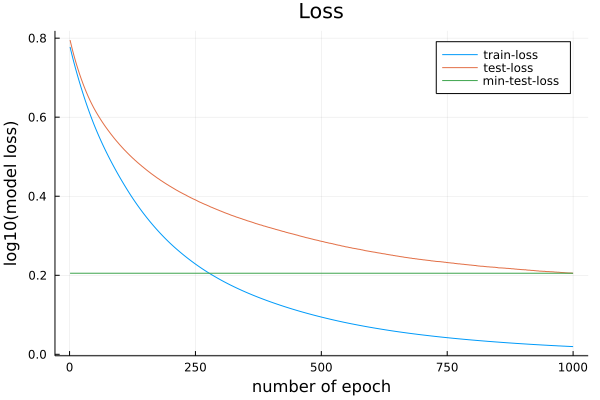

In [25]:
nepoch = 1000
plot(collect(1:nepoch), 
    hcat(log.(10, trainloss .+ 1), 
    log.(10, testloss .+1 ), 
    fill(minimum(log.(10, testloss .+1 )), nepoch)), 
    title = "Loss", 
    label=["train-loss" "test-loss" "min-test-loss"], 
    xlabel="number of epoch", ylabel="log10(model loss)", legend=:topright)
############################################################################################

Let's do inference and see how our model performs on testdata ...

In [27]:
[
Flux.onecold(softmax(model(first(test_loader)[1])), unique(adata.celltypes)) Flux.onecold(first(test_loader)[2], unique(adata.celltypes))
]

128×2 Matrix{String}:
 "L5a"   "L6a"
 "L5a"   "L5a"
 "L5a"   "L5a"
 "L5a"   "L6a"
 "L5a"   "L6a"
 "L5a"   "L5a"
 "L5b"   "L6a"
 "L5a"   "L5a"
 "L5b"   "L5a"
 "L5a"   "L5a"
 "L5a"   "L5a"
 "L5a"   "L5a"
 "L5b"   "L5b"
 ⋮       
 "L4"    "L4"
 "L6b"   "L6a"
 "L2/3"  "L2/3"
 "L6a"   "L6a"
 "L2"    "L2"
 "L6a"   "L6a"
 "L2/3"  "L6a"
 "L2/3"  "L2/3"
 "L2/3"  "L6a"
 "L2/3"  "L6a"
 "L5b"   "L2"
 "L6a"   "L6a"

After having a trained model, we are going to apply IG method, but first we will gain some in depth knowledge 
about IG ... 

First, you will generate a linear interpolation between the **baseline** and a **target**, that we want to get the its ingegrated gradient. Interpolation can be thought as small steps in the feature space between your baseline and input/target, represented by in the original equation $\alpha$.

In [28]:
# Interpolation steps 
msteps = 50
alphas = range(0.0f0, 1.0f0, length=msteps+1)

0.0f0:0.02f0:1.0f0

### Compute Interpolation

In [29]:
# Let's define an interpolation function 
interpolate(baseline, target, alphas) = hcat(map(alpha -> baseline .+ alpha .* (target .- baseline), 
                                        alphas)...) # 180×51 genes x msteps 

interpolate (generic function with 1 method)

Now we want to calculate the gradients. **Gradients** measure the relationship between changes to a feature and changes in the model's predictions. <br>
In our case, the **gradient tells us which gene have the strongest effect on the models predicted class probabilities**.

### Compute Gradients

In Julia, we use `ForwardDiff`. ForwardDiff implements methods to take **derivatives**, **gradients**, **Jacobians**, **Hessians**.

In [30]:
function compute_gradients(model, x::AbstractVector, label_index)
    gradients = ForwardDiff.gradient(x -> softmax(model(x))[label_index], x)
    return gradients
end

compute_gradients (generic function with 1 method)

### Integral Approximation 

Here we compute a numerical approximation of an integral for IG with using Riemann sums(it is the summation in the formula). In this implementation Trapezoidal rule has been used. 

In [31]:
function integral_approx(pathgrads::AbstractMatrix) # assumes features are rows and path values are columns
    # Riemann trapezoidal 
    int_grads = (pathgrads[:,1:(end-2)] + pathgrads[:,3:end])./2
    return vec(mean(int_grads,dims=2))
end

integral_approx (generic function with 1 method)

### Compute Integrated Gradients

Now we put things together and compute integrated gradients ... 

In [32]:
function compute_integrated_gradients(model, baseline, target, label_index; msteps::Int=50)

    alphas = range(0.0f0, 1.0f0, length=msteps+1)
    pathgrads = hcat(
                map(alpha -> compute_gradients(model, vec(interpolate(baseline, target, alpha)), label_index)
                , alphas)...) # #genes=180× #step = 51
    
    igs = integral_approx(pathgrads) # #genes = 180 
    scalefac = (target .- baseline) # #genes = 180
    return scalefac .* igs   # #genes = 180 
end

compute_integrated_gradients (generic function with 1 method)

Let's give the method a shot and see the accumlated gradients 

In [41]:
baseline = first(test_loader)[1][:,1] # first cell in the testset as a baseline 
target = first(test_loader)[1][:,2] # second cell in the testset as a target 
label_index = 7
celltype = unique(adata.celltypes)[label_index]

"L5a"

> **Choosing a baseline:** 
>
> If your data represented by images on a gray scale, a black image (e.g. pixels values are zeros) can be a natural choice. 
> **Discussion:** what if your data represented by cells and genes are the features?

In [45]:
integrated_gradient = compute_integrated_gradients(model, baseline, target, label_index);

180-element Vector{Float32}:
 -8.757472f-5
  0.0
 -9.843328f-5
  0.0
  0.0
 -0.00074680796
 -0.0
 -0.00031007238
  0.00074985076
  0.0
 -0.0
 -2.1628027f-6
  0.0
  ⋮
  0.0
  0.0
 -0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
 -0.0
  0.0
 -0.0
  0.0

Let's pack the integrated gradients in a dictionary and invistigate the results 

In [46]:
integrated_gradient_results = Dict("genes" => adata.vars["gene_names"],
                "accumulated_gradients" => integrated_gradient) 

Dict{String, Vector} with 2 entries:
  "accumulated_gradients" => Float32[-8.75747f-5, 0.0, -9.84333f-5, 0.0, 0.0, -…
  "genes"                 => Any["Adora1", "Adra1a", "Adra1b", "Adra1d", "Adra2…

In [48]:
sorted_results = sort(collect(integrated_gradient_results), by = x->x[1])

2-element Vector{Pair{String, Vector}}:
 "accumulated_gradients" => Float32[-8.757472f-5, 0.0, -9.843328f-5, 0.0, 0.0, -0.00074680796, -0.0, -0.00031007238, 0.00074985076, 0.0  …  -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0]
                 "genes" => Any["Adora1", "Adra1a", "Adra1b", "Adra1d", "Adra2a", "Adrb1", "Adrb2", "Aqp4", "Arf5", "Batf3"  …  "Th", "Tnfaip8l3", "Tnmd", "Tpbg", "Tph2", "Ucma", "Vip", "Vtn", "Wt1", "Xdh"]

Using integrated gradients, we can see which gene has affected the model in classifiying a cell.

In [47]:
[integrated_gradient_results["accumulated_gradients"] integrated_gradient_results["genes"]]

180×2 Matrix{Any}:
 -8.75747f-5   "Adora1"
  0.0          "Adra1a"
 -9.84333f-5   "Adra1b"
  0.0          "Adra1d"
  0.0          "Adra2a"
 -0.000746808  "Adrb1"
 -0.0          "Adrb2"
 -0.000310072  "Aqp4"
  0.000749851  "Arf5"
  0.0          "Batf3"
 -0.0          "Bcl6"
 -2.1628f-6    "Bgn"
  0.0          "Brca1"
  ⋮            
  0.0          "Tcerg1l"
  0.0          "Tcf7l2"
 -0.0          "Th"
 -0.0          "Tnfaip8l3"
  0.0          "Tnmd"
 -0.0          "Tpbg"
  0.0          "Tph2"
 -0.0          "Ucma"
 -0.0          "Vip"
  0.0          "Vtn"
 -0.0          "Wt1"
  0.0          "Xdh"

In [51]:
@show(adata.vars["gene_names"])

adata.vars["gene_names"] = Any["Adora1", "Adra1a", "Adra1b", "Adra1d", "Adra2a", "Adrb1", "Adrb2", "Aqp4", "Arf5", "Batf3", "Bcl6", "Bgn", "Brca1", "C1qb", "Calb2", "Car12", "Car4", "Cbln4", "Cd9", "Cdh13", "Cdk6", "Chat", "Chodl", "Chrm1", "Chrm2", "Chrm3", "Chrm4", "Chrna1", "Chrna2", "Chrna3", "Chrna4", "Chrna5", "Chrna7", "Chrnb1", "Chrnb2", "Chrnb3", "Cnr1", "Cnr2", "Col6a1", "Cpne5", "Crip1", "Crispld2", "Cspg4", "Ctgf", "Ctss", "Ctxn3", "Cx3cr1", "Cxcl14", "Ddit4l", "Deptor", "Drd1a", "Drd5", "Enpp2", "Enpp6", "Exosc7", "F3", "Flt1", "Foxp2", "Frmd7", "Fyn", "Gabbr1", "Gabbr2", "Gabra1", "Gabra2", "Gabra3", "Gabra4", "Gabra5", "Gabrb1", "Gabrb2", "Gabrb3", "Gabrd", "Gabrg1", "Gabrg2", "Gabrg3", "Gfap", "Gja1", "Glra2", "Glra3", "Glrb", "Gpc3", "Gpr34", "Gpx3", "Gria1", "Gria2", "Gria3", "Gria4", "Grid1", "Grik1", "Grik2", "Grik3", "Grik4", "Grik5", "Grin1", "Grin2a", "Grin2b", "Grin2d", "Grin3a", "Grina", "Grm1", "Grm2", "Grm3", "Grm4", "Grm5", "Grm7", "Grm8", "Hrh1", "Hrh2", "H

180-element Vector{Any}:
 "Adora1"
 "Adra1a"
 "Adra1b"
 "Adra1d"
 "Adra2a"
 "Adrb1"
 "Adrb2"
 "Aqp4"
 "Arf5"
 "Batf3"
 "Bcl6"
 "Bgn"
 "Brca1"
 ⋮
 "Tcerg1l"
 "Tcf7l2"
 "Th"
 "Tnfaip8l3"
 "Tnmd"
 "Tpbg"
 "Tph2"
 "Ucma"
 "Vip"
 "Vtn"
 "Wt1"
 "Xdh"

### References 

[Integrated gradients in Tensorflow](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) <br>
[Axiomatic Attribution for Deep Networks by Mukund Sundararajan](https://arxiv.org/abs/1703.01365)

<!--bibtex

@article{DBLP:journals/corr/SundararajanTY17,
  author    = {Mukund Sundararajan and
               Ankur Taly and
               Qiqi Yan},
  title     = {Axiomatic Attribution for Deep Networks},
  journal   = {CoRR},
  volume    = {abs/1703.01365},
  year      = {2017},
  url       = {http://arxiv.org/abs/1703.01365},
  eprinttype = {arXiv},
  eprint    = {1703.01365},
  timestamp = {Mon, 13 Aug 2018 16:48:32 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/SundararajanTY17.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
-->